In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import sample
from scipy.integrate import odeint
import scipy.sparse as sp
import pandas as pd
import numpy.linalg as lg
import operator
%matplotlib inline

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


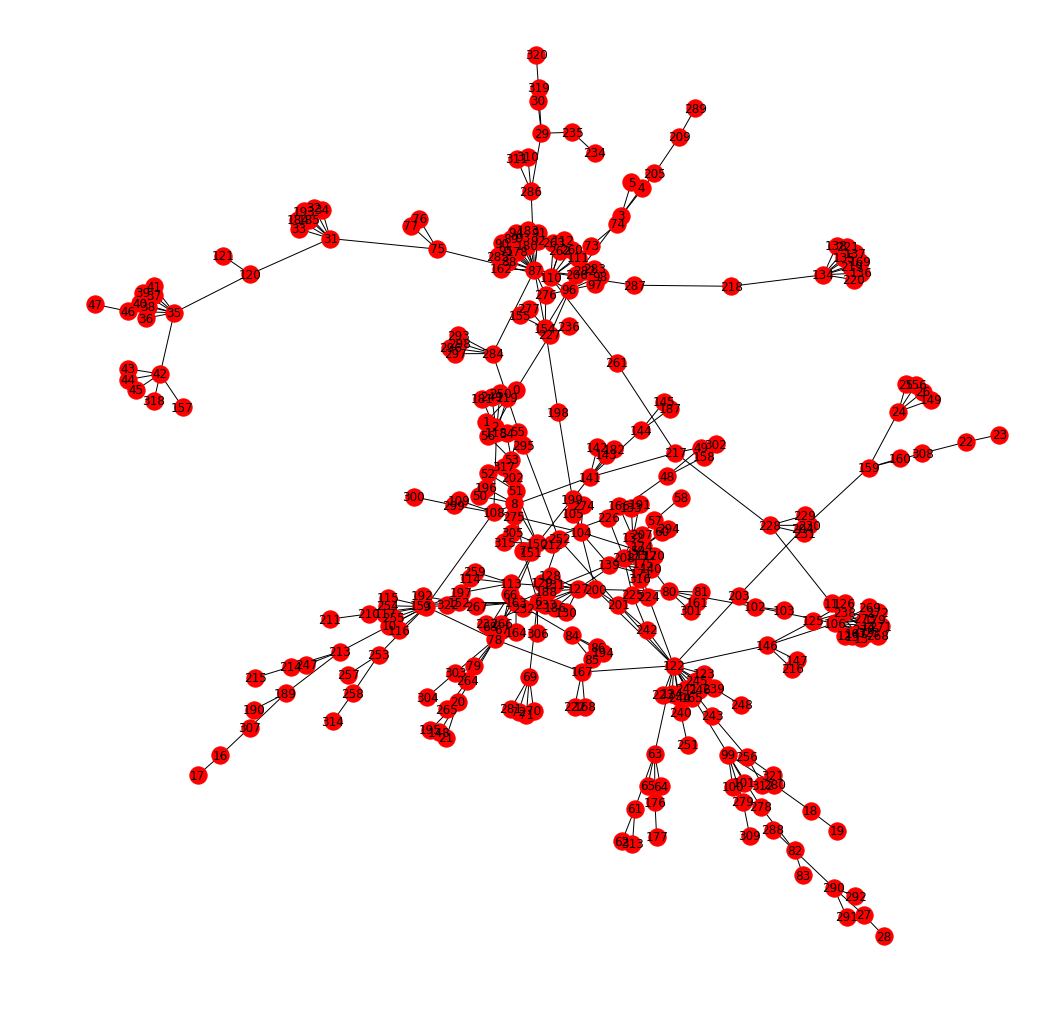

In [10]:
G=nx.read_weighted_edgelist('ColoSpg.txt')# Colorado Springs dataset
H=nx.read_edgelist('oregon2.txt')# Oregon dataset
A=nx.to_numpy_matrix(G)
G=nx.from_numpy_matrix(A)
plt.figure(figsize=(18,18))

nx.draw_networkx(G)
plt.axis('off')
#plt.savefig("pth2.png")
plt.show()


### Oregon graph too large 

In [629]:
A2=nx.to_numpy_matrix(H)  
H=nx.from_numpy_matrix(A2)
# plt.figure(figsize=(18,18))
# nx.draw_networkx(H)
# plt.axis('off')
# #plt.savefig("pth2.png")
# plt.show()

# NLDS

In [36]:
def epi_step(A, p, n, gamma, beta):
    q = np.zeros(n)
    for i in range(n):
        z = 1
        f,f1,v=sp.find(A[:,i])# returns the non-zero elements in a sparse matrix
        for j in f:
            z = z*(1-beta*A[i,j]*p[j]) #zeta
        q[i] = (1-p[i])*z+gamma*p[i]*z # probability of not being infected
    p = 1-q 
    
    return p# probability of  being infected

In [37]:
def trial(A, gamma, beta, m, init):
    t = np.zeros(m) #timesteps
    n = len(A) #number of nodes
    p=init
    for i in range(m): 
        t[i] = sum(p) 
        # probability of infection
        p = epi_step(A, p, n, gamma, beta)
    return t,p #number of infectives, probability

In [39]:
# initially infect node 0
m=40
gamma=.24
beta=.75
init = np.zeros(len(A))
init[0] = 1
t1,p1 = trial(A,gamma,beta,m,init)#number of infectives, probability



In [633]:
#Fraction of infected nodes
d=t1/len(G.nodes())
d

array([0.00308642, 0.00929012, 0.01399669, 0.01894267, 0.04333769,
       0.08154684, 0.12127027, 0.14966464, 0.17553757, 0.21007205,
       0.26440984, 0.34311796, 0.45443007, 0.5825871 , 0.69041184,
       0.769362  , 0.8162427 , 0.84825048, 0.87129774, 0.88781429,
       0.90153422, 0.91436409, 0.92985787, 0.94222677, 0.94747539,
       0.94880453, 0.94908865, 0.94914851, 0.94916127, 0.94916404,
       0.94916465, 0.94916479, 0.94916483, 0.94916483, 0.94916483,
       0.94916483, 0.94916483, 0.94916484, 0.94916484, 0.94916484])

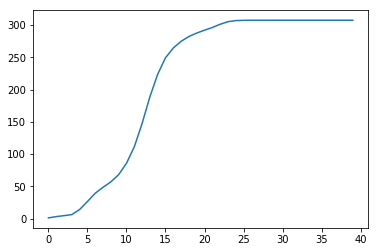

In [634]:
plt.clf()
plt.plot(range(m),t1)
plt.savefig('fig1.png')

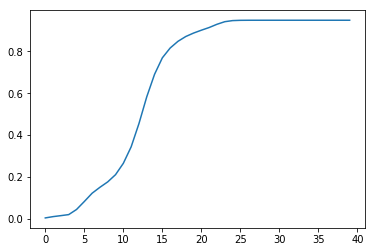

In [635]:
# plt.clf()
# plt.plot(range(m),d)
# plt.savefig('fig1.png')

In [636]:
# initially infect node 10
m1=100
gamma=.45
beta=.2
init = np.zeros(len(A))
init[10] = 1
t2,p1 = trial(A,gamma,beta,m1,init)

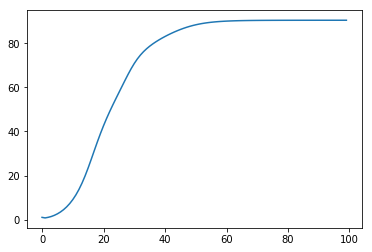

In [637]:
plt.clf()
plt.plot(range(m1),t2)
plt.savefig('fig2.png')

In [638]:
# # Random initial infectivity (with mean 1)
# m3=20
# gamma=.45
# beta=.2
# init = np.random.rand(len(A))
# init =init/sum(init)
# t3,p1 = trial(A,gamma,beta,m3,init)

In [639]:
# plt.clf()
# plt.plot(range(m3),t3)
# #plt.savefig('fig3.png')

# SIS Model -differential equation

$\frac{dI} {dt}=\beta S I - \gamma I$

In [14]:
def my_SIS(g,beta,gamma,t,ax1):   
    N = len(g.nodes()) # Total population
    I0 = 1 #initial infected 
    S0 = N - I0 #initial susceptibles


    def SIS(y, t, N, beta, gamma):
        S, I = y
        dSdt = -beta * S * I / N +gamma*I


        dIdt = beta * S * I / N - gamma * I
        return dSdt, dIdt


    y0 = S0, I0 #Initial condituions

    diff = odeint(SIS, y0, t, args=(N, beta, gamma))
    S, I = diff.T


    a=ax1.plot(t, I/N, 'r',label=("SIS",round(max(I/N),2)))
    
#     plt.xlabel('Timesteps')
#     plt.ylabel('fraction of infectives')
#     plt.ylim(0,1)

#     plt.show()
    return a


# Kephart White Model

In [40]:
#average degree of networks
def ave_deg(g):
    degrees=dict(g.degree())
    list_deg=list(degrees.values())
    av_k=np.mean(list_deg)
    return av_k


In [16]:
def my_KW(g,beta,gamma,t,ax1): # The Kephart and White Model
    N=len(g.nodes())
        
    def kephart(eta,t): 

        return beta*ave_deg(g)*eta*(1-eta/N)-gamma*eta

    eta0=1
    y=odeint(kephart,eta0,t)
    a=ax1.plot(t, y/N, 'k',label=("KW",(max(y/N),2)))
    return a

# Epidemics Module in Python

In [1168]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

# Model selection
model = ep.SISModel(G)

# Model Configuration
for i in range(5):
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', 0.3) #infection rate
    cfg.add_model_parameter('lambda', 0.15) #recovery rate
    cfg.add_model_parameter("fraction_infected", 1/len(G.nodes()))
    model.set_initial_status(cfg)

# Simulation execution
#iterations = model.iteration_bunch(200)

In [1169]:
iterations = model.iteration_bunch(60, node_status=True)
trends = model.build_trends(iterations)
#trends#iterations

100%|██████████| 60/60 [00:00<00:00, 744.66it/s]


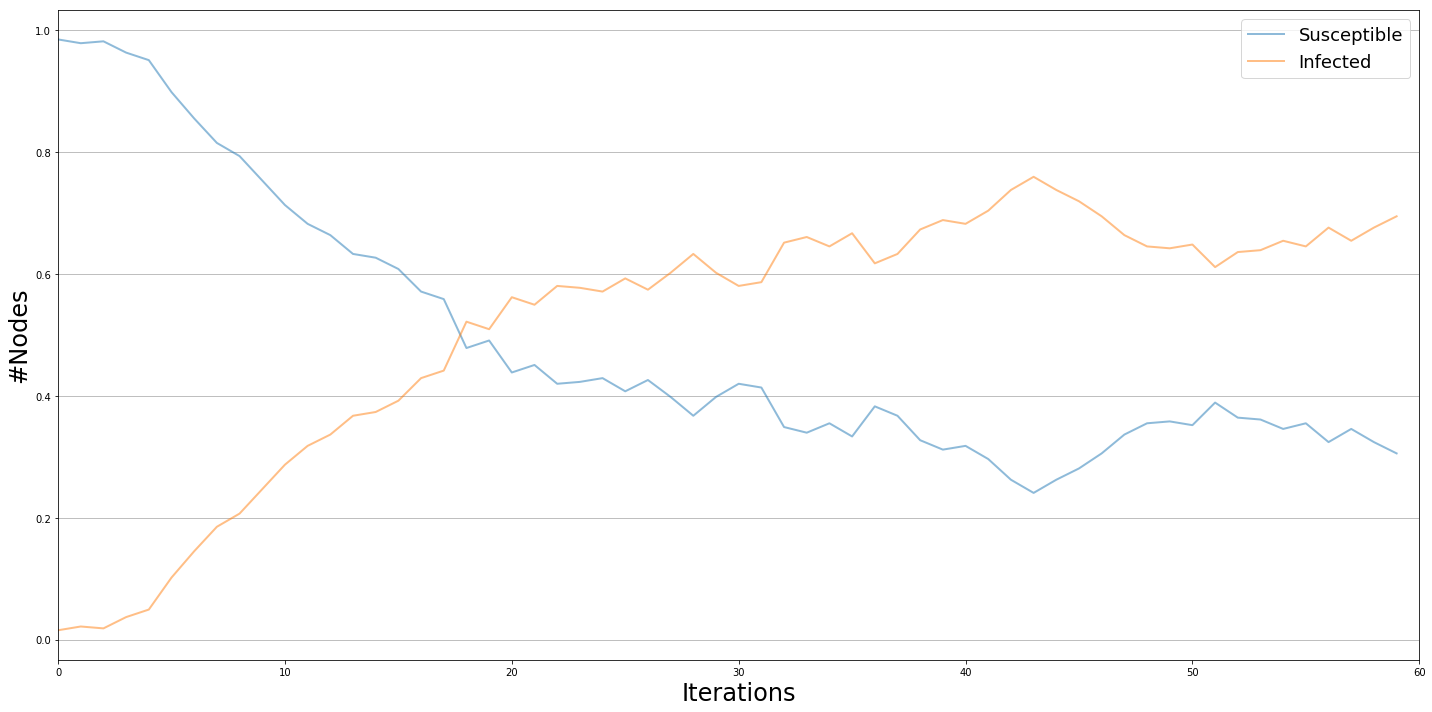

In [1170]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model, trends)
#plt.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
viz.plot()

# Comparing Models

# Colorado Springs

In [885]:
m=100
beta=.14
gamma=0.08
init = np.zeros(len(A))
init[0] = 1
t4,p1 = trial(A,gamma,beta,m4,init)

<Figure size 432x288 with 0 Axes>

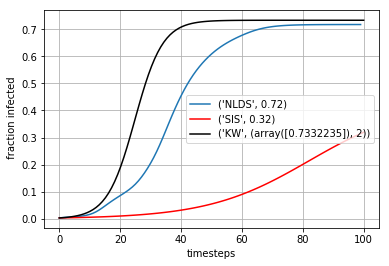

In [886]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m4),t4/len(G.nodes()),label=("NLDS",round(max(t4/len(G.nodes())),2)))
my_SIS(G,beta,gamma,t,ax1)
my_KW(G,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

#print("max NLDS=",(round(max(t4/len(G.nodes())),2)))

# Random graphs

# Erdos Renyi

$\bar{k}=np, \ \ \ \ p=\bar{k}/n$

In [18]:
p=0.024

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


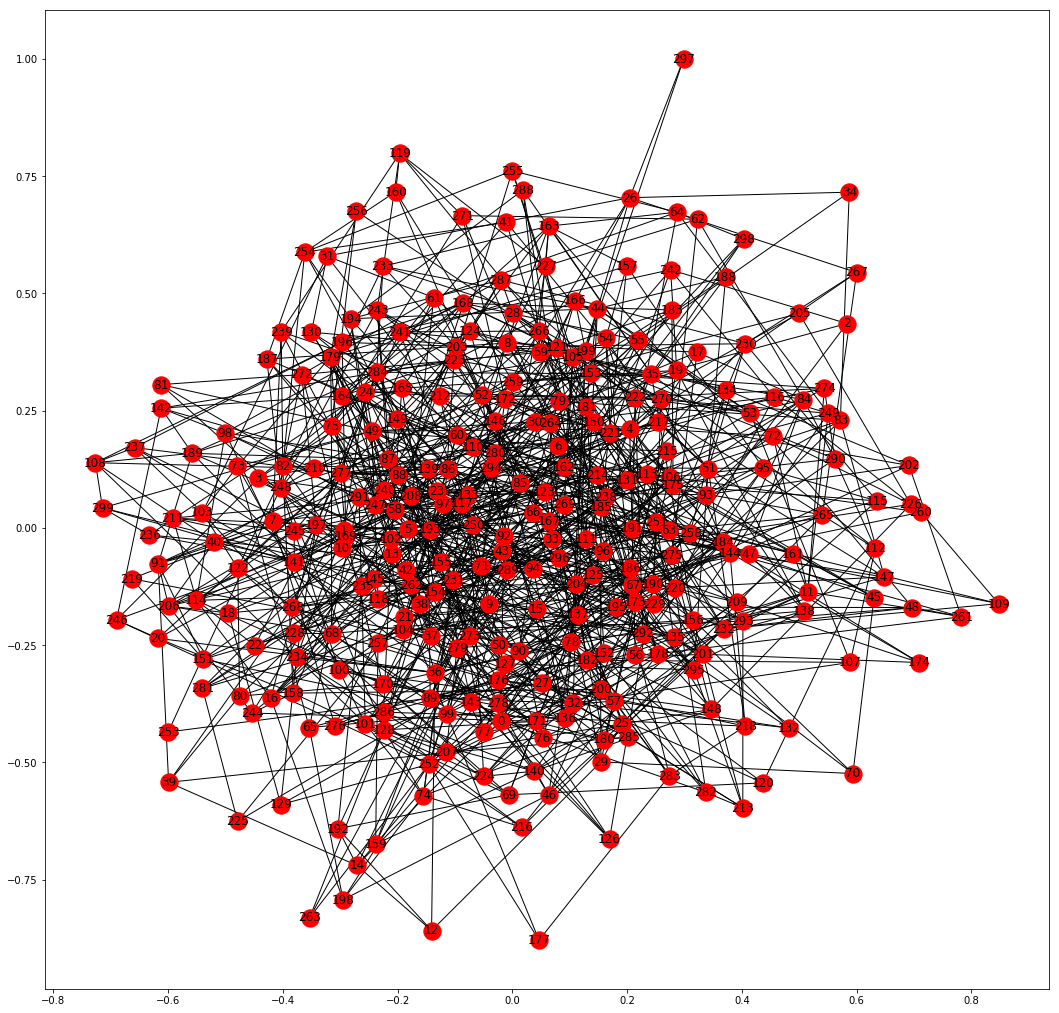

ValueError: too many values to unpack (expected 2)

<Figure size 1296x1296 with 0 Axes>

In [19]:
ER=nx.erdos_renyi_graph(300,p,seed=1)
A1=nx.to_numpy_matrix(ER)
plt.figure(figsize=(18,18))
nx.draw_networkx(ER)
plt.show()

b=nx.connected_components(ER)
plt.figure(figsize=(18,18))
nx.draw_networkx(b)
plt.show()

In [63]:
nx.connected_components?

In [26]:

m4=100
beta=.14
gamma=0.24
init = np.zeros(len(A1))
init[0] = 1
t4,p1 = trial(A1,gamma,beta,m4,init)

<Figure size 432x288 with 0 Axes>

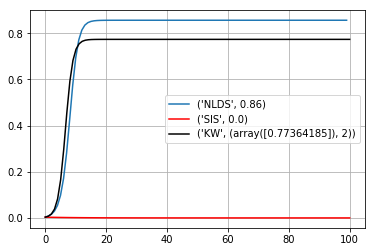

In [27]:
beta=0.14
gamma=0.24
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m4),t4/len(ER.nodes()),label=("NLDS",round(max(t4/len(ER.nodes())),2)))
my_SIS(ER,beta,gamma,t,ax1)
my_KW(ER,beta,gamma,t,ax1)
plt.grid()
plt.legend()
plt.show()

# Barabasi Albert

# Drugs Network

In [48]:
D=nx.read_weighted_edgelist('Drugs.txt')
A3=nx.to_numpy_matrix(D)
D=nx.from_numpy_matrix(A3)
# plt.figure(figsize=(18,18))

# nx.draw_networkx(D)
# plt.axis('off')
# #plt.savefig("pth2.png")
# plt.show()


In [653]:
m5=100
beta=.14
gamma=0.08
init = np.zeros(len(A3))
init[0] = 1
t5,p1 = trial(A3,gamma,beta,m5,init)

In [654]:
# beta=0.14
# gamma=0.08
# t=np.linspace(0,100,100)
# plt.clf()
# fig1=plt.figure()
# ax1=fig1.add_subplot(111)
# ax1.plot(range(m5),t5/len(D.nodes()),label=("NLDS",round(max(t5/len(D.nodes())),2)))
# my_SIS(D,beta,gamma,t,ax1)
# my_KW(D,beta,gamma,t,ax1)
# plt.xlabel('timesteps')
# plt.ylabel(' fraction infected')
# plt.grid()
# plt.legend()
# plt.show()


# Dolphins interactions dataset


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


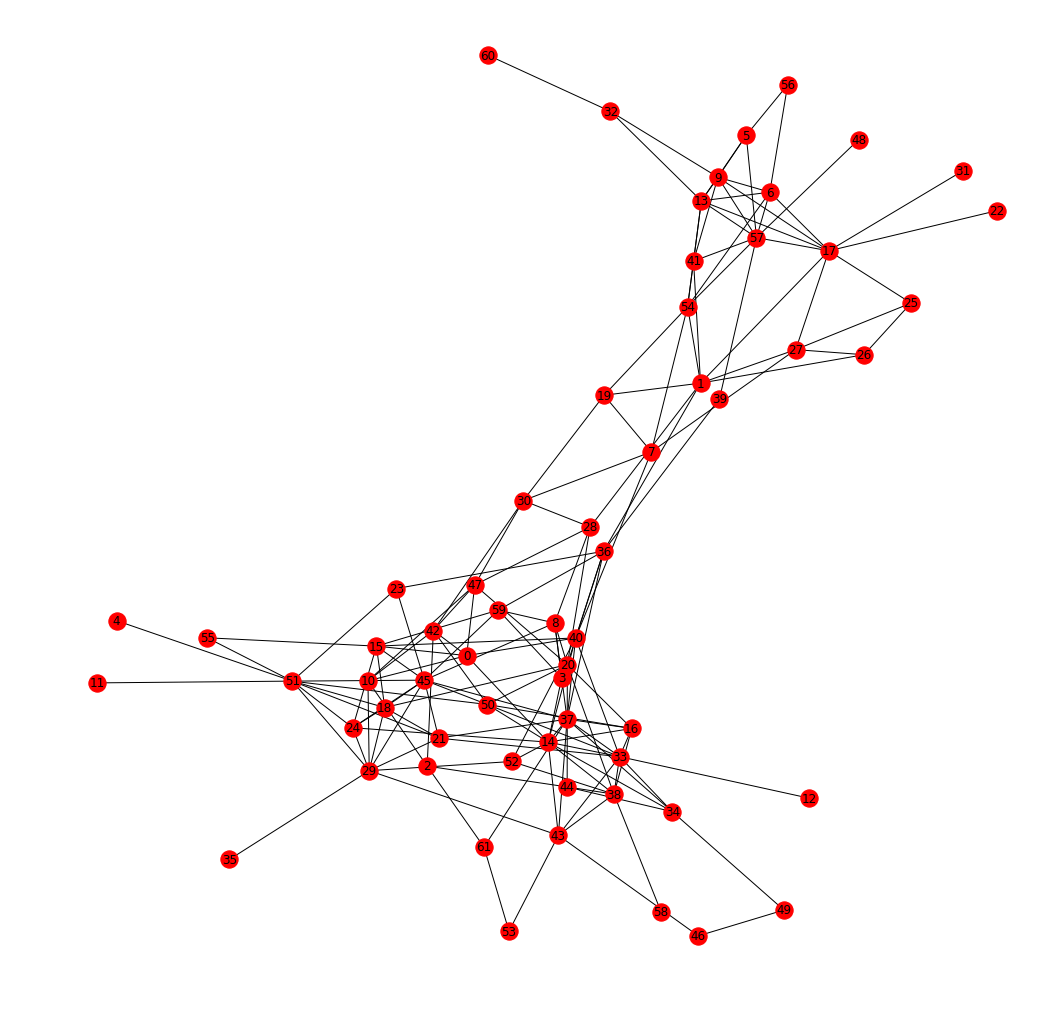

In [49]:
Z=nx.read_gml("dolphins.gml")
P=nx.to_numpy_matrix(Z)
Z=nx.from_numpy_matrix(P)
plt.figure(figsize=(18,18))

nx.draw_networkx(Z)
plt.axis('off')
#plt.savefig("pth2.png")
plt.show()


In [656]:
m7=100
beta=.14
gamma=0.08
init = np.zeros(len(P))
init[0] = 1
t7,p1 = trial(P,gamma,beta,m7,init)

<Figure size 432x288 with 0 Axes>

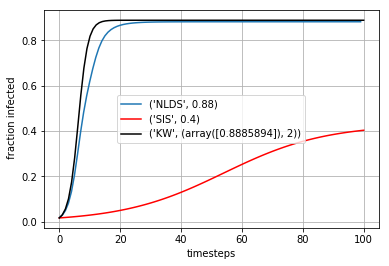

In [657]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
#ax1.set_xticks(np.arange(0, 1, 0.01))
#ax1.set_yticks(np.arange(0, 1, 0.01))
ax1.plot(range(m7),t7/len(Z.nodes()),label=("NLDS",round(max(t7/len(Z.nodes())),2)))
my_SIS(Z,beta,gamma,np.linspace(0,100,100),ax1)
my_KW(Z,beta,gamma,t,ax1)
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.grid()
plt.show()

# Les Miserables Datasets

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


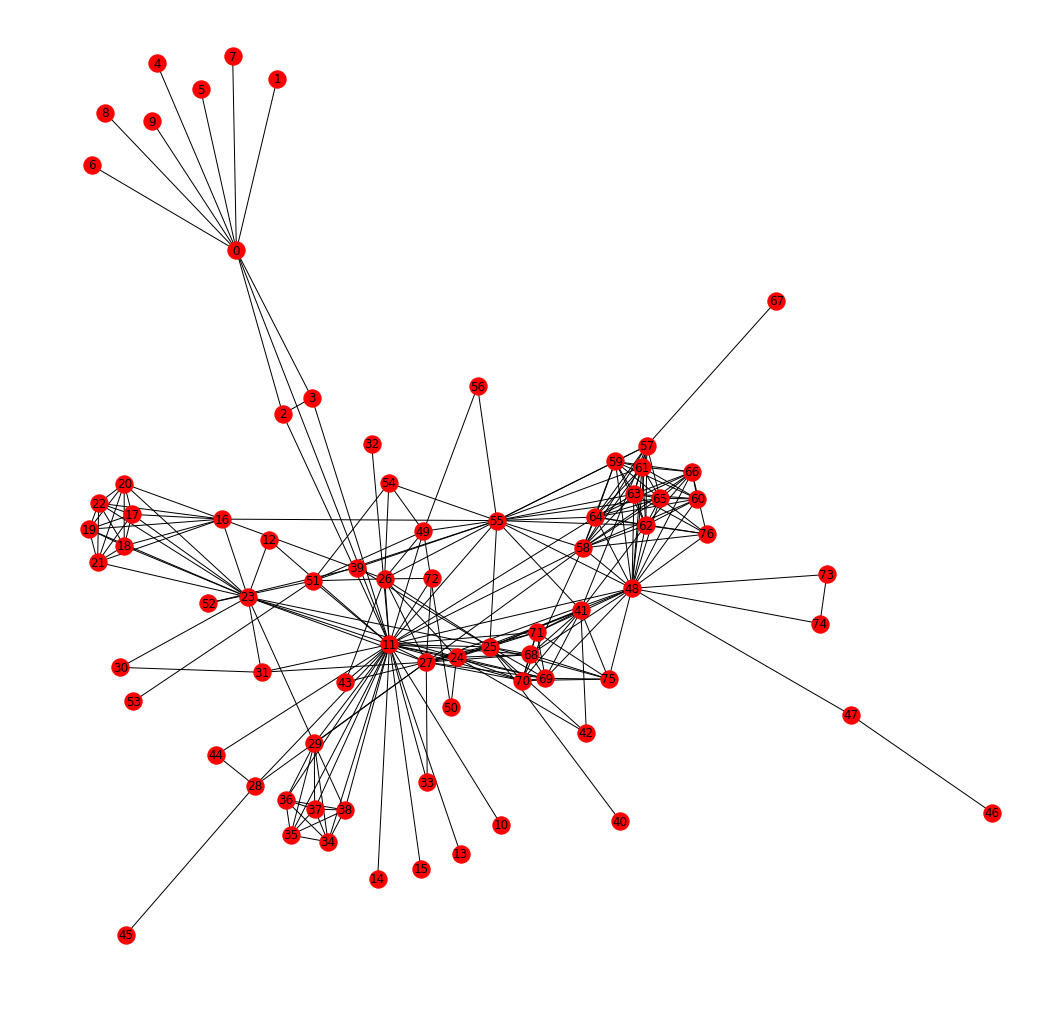

In [5]:
F=nx.read_gml("lesmis.gml")
P1=nx.to_numpy_matrix(F)
F=nx.from_numpy_matrix(P1)
plt.figure(figsize=(18,18))

nx.draw_networkx(F)
plt.axis('off')
#plt.savefig("pth2.png")
plt.show()

In [793]:
m=100
beta=.14
gamma=0.08
init = np.zeros(len(P1))
init[0] = 1
t8,p1 = trial(P1,gamma,beta,m7,init)

<Figure size 432x288 with 0 Axes>

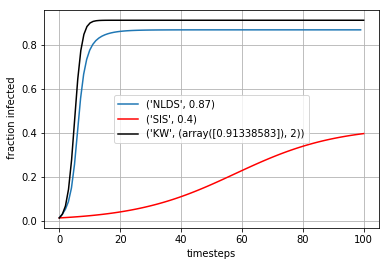

In [794]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m7),t8/len(F.nodes()),label=("NLDS",round(max(t8/len(F.nodes())),2)))
my_SIS(F,beta,gamma,np.linspace(0,100,100),ax1)
my_KW(F,beta,gamma,t,ax1)
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.grid()
plt.legend()
plt.show()

# Average degrees

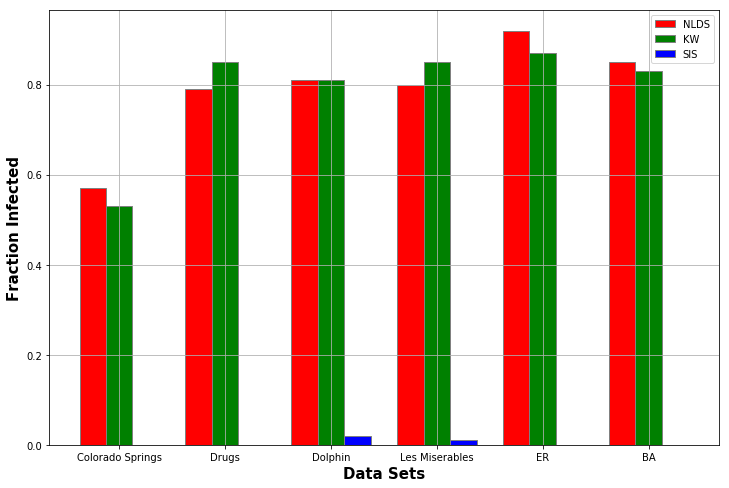

In [25]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
NLDS = [0.57,0.79, .81,0.8,0.92,.85]
KW = [0.53, 0.85, 0.81, 0.85,.87,.83]
SIS = [0, 0, 0.02, 0.01,0,0]
 
# Set position of bar on X axis
br1 = np.arange(6)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, NLDS, color ='r', width = barWidth,
        edgecolor ='grey', label ='NLDS')
plt.bar(br2, KW, color ='g', width = barWidth,
        edgecolor ='grey', label ='KW')
plt.bar(br3, SIS, color ='b', width = barWidth,
        edgecolor ='grey', label ='SIS')
 
# Adding Xticks
#plt.title("Beta=0.14 Gamma=0.14")
plt.legend()
plt.grid()
plt.xlabel('Data Sets', fontweight ='bold', fontsize = 15)
plt.ylabel('Fraction Infected', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(NLDS))],
        ['Colorado Springs', 'Drugs', 'Dolphin', 'Les Miserables',"ER",'BA'])
plt.show()

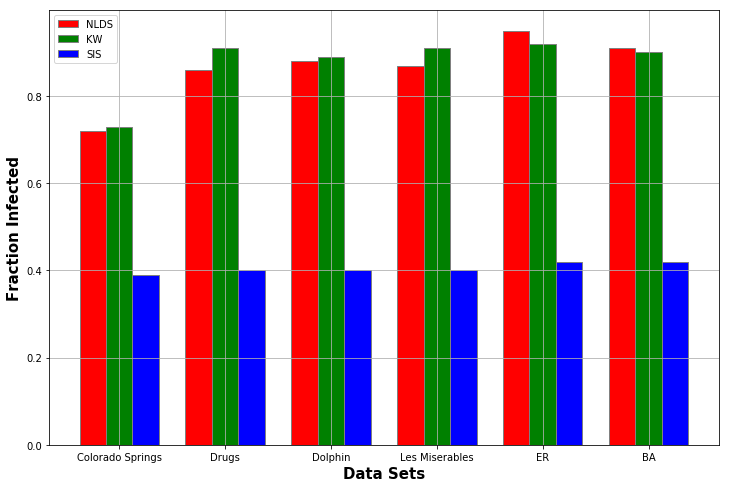

In [22]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
NLDS = [0.72, 0.86, 0.88, 0.87,.95,.91]
KW = [0.73, 0.91, 0.89, 0.91,.92,.90]
SIS = [0.39, 0.4, 0.4, 0.4,0.42,.42]
 
# Set position of bar on X axis
br1 = np.arange(6)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, NLDS, color ='r', width = barWidth,
        edgecolor ='grey', label ='NLDS')
plt.bar(br2, KW, color ='g', width = barWidth,
        edgecolor ='grey', label ='KW')
plt.bar(br3, SIS, color ='b', width = barWidth,
        edgecolor ='grey', label ='SIS')
 
# Adding Xticks
#plt.title("Beta=0.14, Gamma=0.08")
plt.legend()
plt.xlabel('Data Sets', fontweight ='bold', fontsize = 15)
plt.ylabel('Fraction Infected', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(KW))],
        ['Colorado Springs', 'Drugs', 'Dolphin', 'Les Miserables','ER','BA'])
plt.grid()
plt.show()

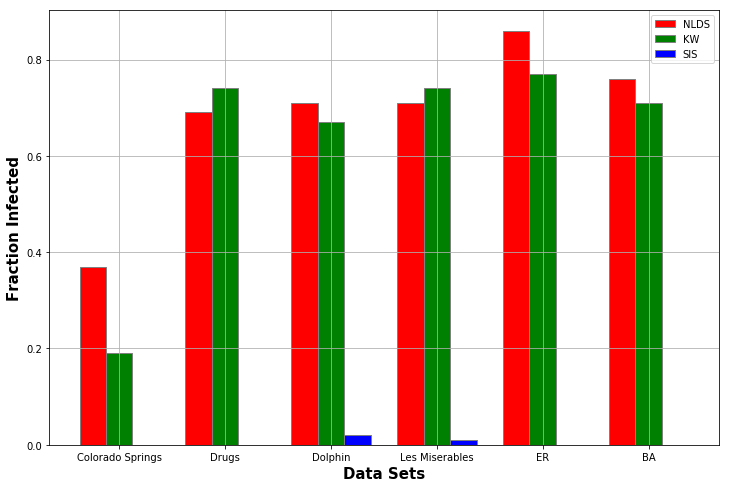

In [28]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
NLDS = [0.37, 0.69, 0.71, 0.71,0.86,.76]
KW = [0.19, 0.74, 0.67, 0.74,0.77,.71]
SIS = [0., 0., 0.02, 0.01,0,0]
 
# Set position of bar on X axis
br1 = np.arange(6)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, NLDS, color ='r', width = barWidth,
        edgecolor ='grey', label ='NLDS')
plt.bar(br2, KW, color ='g', width = barWidth,
        edgecolor ='grey', label ='KW')
plt.bar(br3, SIS, color ='b', width = barWidth,
        edgecolor ='grey', label ='SIS')
 
# Adding Xticks
#plt.title("Beta=0.14, Gamma=0.24")
plt.legend()
plt.grid()
plt.xlabel('Data Sets', fontweight ='bold', fontsize = 15)
plt.ylabel('Fraction Infected', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(KW))],
        ['Colorado Springs', 'Drugs', 'Dolphin', 'Les Miserables','ER','BA'])

plt.show()

https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

# Vaccinating hubs

In [1125]:

def visualisation(g):
    """Function to visualise the network
    and highlight the ten nodes with the highest degree
    """
    deg=np.array(list(dict(g.degree()).values())).astype(float) 
    deg_sort=sorted(deg, reverse=True)#sorting degrees
    mx=deg_sort[:10]
    a=[]
    for nodes in g.nodes:
        if g.degree(nodes) in mx:
            a.append(nodes)   
    return a

In [1126]:
visualisation(G)

[9, 31, 35, 87, 106, 110, 122, 127, 134, 139, 150]

In [1058]:
def hubs(g):
    #a=sample(list(g.nodes()), 10)
    h=g.copy()
    h.remove_nodes_from(visualisation(g))
    A=nx.to_numpy_matrix(h)
    h=nx.from_numpy_matrix(A)

    return A

In [1059]:
def hub_nodes_removed(g):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(hubs(g)))
    init[6] = 1
    t,p1 = trial(hubs(g),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(hubs(g)),label=('hubs'))
    b=plt.legend()
    return a,b

# random nodes

In [668]:
def rand_nodes(g):
    a=sample(list(g.nodes()), 10)
#     h=g.copy()
#     h.remove_nodes_from(a)
#     A=nx.to_numpy_matrix(h)
#     h=nx.from_numpy_matrix(A)

    return a

In [669]:
# def random_nodes_removed(g,ax1):
#     m=100
#     gamma=.08
#     beta=.14
#     init = np.zeros(len(rand_nodes(g)))
#     init[119] = 1
#     t,p1 = trial(rand_nodes(g),gamma,beta,m,init)

#     a=ax1.plot(range(m),t/len(rand_nodes(g)),label="random")
#     #b=plt.legend()
#     return a

# Node Betweenness

In [670]:

def btwn(g):
    d=nx.betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 
    f= e[:10]
#     h=g.copy()
#     h.remove_nodes_from(f)
#     A=nx.to_numpy_matrix(h)
#     h=nx.from_numpy_matrix(A)

    return f

In [671]:
# def highest_betweenness_nodes_removed(g,ax1):
#     m=100
#     gamma=.08
#     beta=.14
#     init = np.zeros(len(btwn(g)))
#     init[0] = 1
#     t,p1 = trial(btwn(g),gamma,beta,m,init)

#     a=ax1.plot(range(m),t/len(btwn(g)),label="betweenness")
#     #b=plt.legend()
#     return a

# Eigen Centrality

In [672]:
def eigen_centrality(g):
    d=nx.eigenvector_centrality_numpy(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 
    f=e[:10]
#     h=g.copy()
#     h.remove_nodes_from(f)
#     A=nx.to_numpy_matrix(h)
#     h=nx.from_numpy_matrix(A)

    return f

In [673]:
# def highest_eigen_nodes_removed(g,ax1):
#     m=100
#     gamma=.08
#     beta=.14
#     init = np.zeros(len(eigen_centrality(g)))
#     init[219] = 1
#     t,p1 = trial(eigen_centrality(g),gamma,beta,m,init)

#     a=ax1.plot(range(m),t/len(eigen_centrality(g)),label="eigen")
#     #b=plt.legend()
#     return a

In [876]:
ER1=ER.copy()
ER1.remove_nodes_from(visualisation(ER))
A_ER=nx.to_numpy_matrix(ER1)
ER1=nx.from_numpy_matrix(A_ER)

ER2=ER.copy()
ER2.remove_nodes_from(rand_nodes(ER))
A_ER2=nx.to_numpy_matrix(ER2)
ER2=nx.from_numpy_matrix(A_ER2)

ER3=ER.copy()
ER3.remove_nodes_from(btwn(ER))
A_ER3=nx.to_numpy_matrix(ER3)
ER3=nx.from_numpy_matrix(A_ER3)

ER4=ER.copy()
ER4.remove_nodes_from(eigen_centrality(ER))
A_ER4=nx.to_numpy_matrix(ER4)
ER4=nx.from_numpy_matrix(A_ER4)




/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

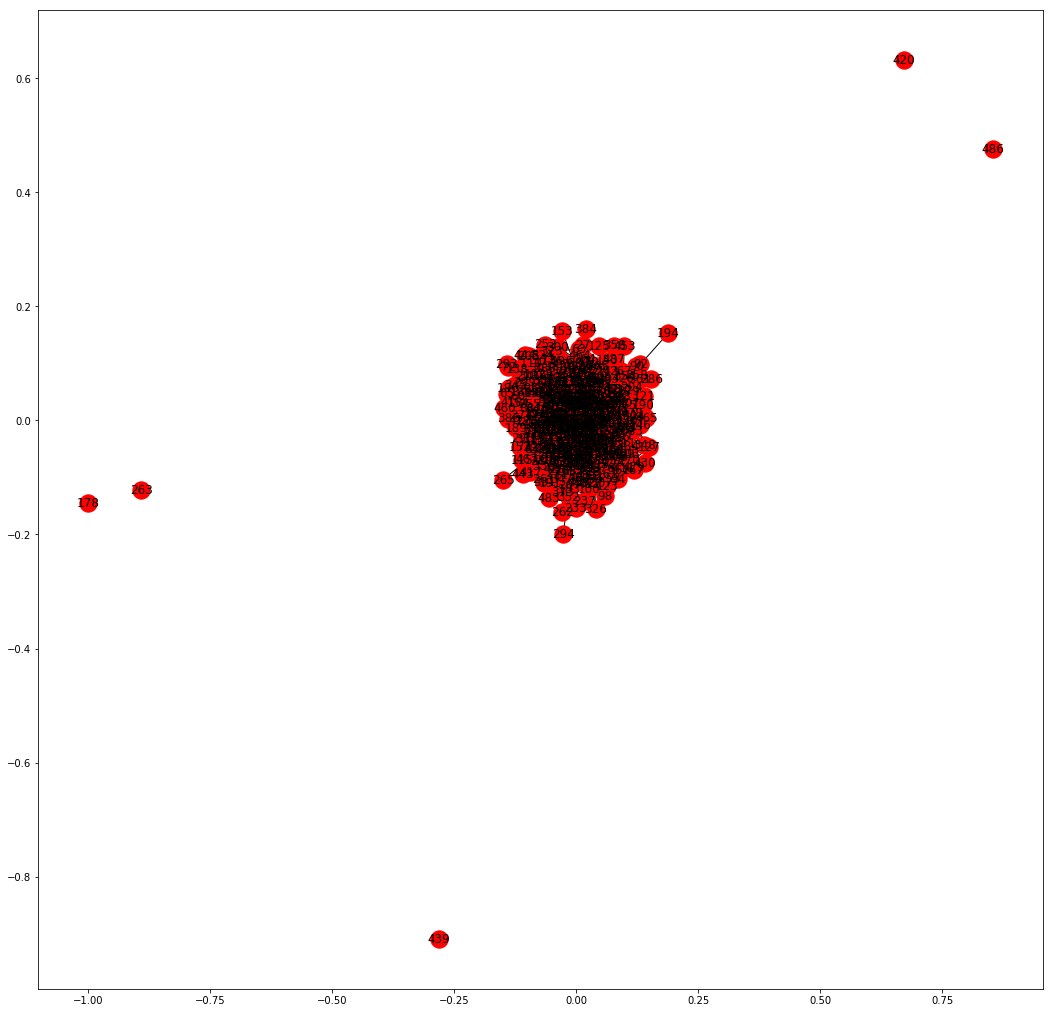

<Figure size 1296x1296 with 0 Axes>

In [881]:
# plt.clf()
# plt.figure(figsize=(18,18))
# pos = nx.spring_layout(ER4)
# nx.draw_networkx(ER4)
# plt.figure(figsize=(18,18))
# #plt.title(title)
# plt.show()

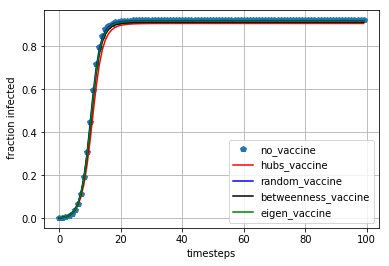

In [882]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A_ER))
init[0] = 1
t_E,p1 = trial(A_ER,gamma,beta,m,init)
               
init = np.zeros(len(A_ER2))
init[0] = 1
t_E2,p1 = trial(A_ER2,gamma,beta,m,init)  

init = np.zeros(len(A_ER3))
init[0] = 1
t_E3,p1 = trial(A_ER3,gamma,beta,m,init)

init = np.zeros(len(A_ER4))
init[0] = 1
t_E4,p1 = trial(A_ER4,gamma,beta,m,init)
               
fig1=plt.figure()
ax1=fig1.add_subplot(111)

ax1.plot(range(m4),t4/len(ER.nodes()),'p',label=("no_vaccine"))
plt.plot(range(m),t_E/len(ER1.nodes()),'r',label=("hubs_vaccine"))
plt.plot(range(m),t_E2/len(ER2.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t_E3/len(ER3.nodes()),'k',label=("betweenness_vaccine"))
plt.plot(range(m),t_E4/len(ER4.nodes()),'g',label=("eigen_vaccine"))

plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()


### Colorado Springs

In [1060]:
gnow=G.copy()
gnow.remove_nodes_from(visualisation(G))

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

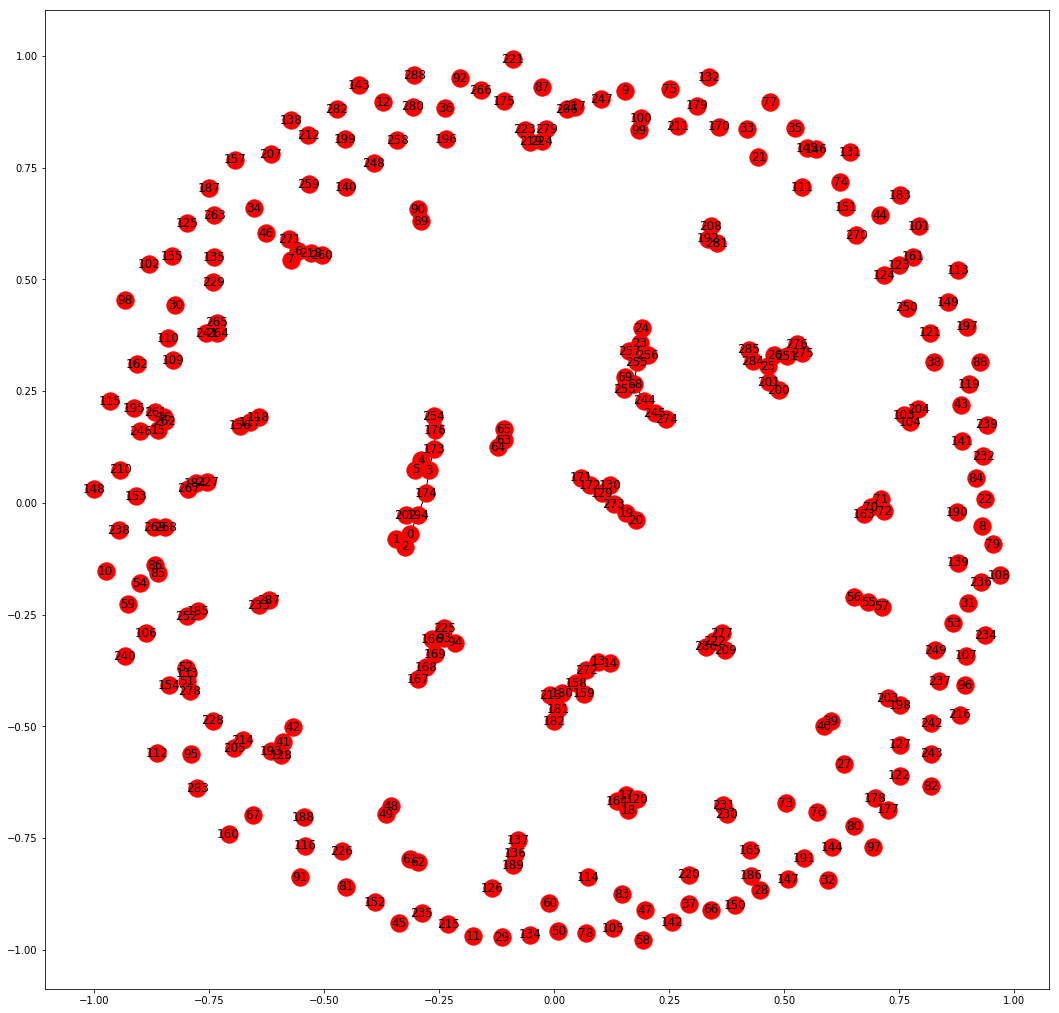

<Figure size 1296x1296 with 0 Axes>

In [1061]:
A5=nx.to_numpy_matrix(gnow)
gnow=nx.from_numpy_matrix(A5)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(gnow)
nx.draw_networkx(gnow)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [1062]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A5))
init[200] = 1
t_1,p1 = trial(A5,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

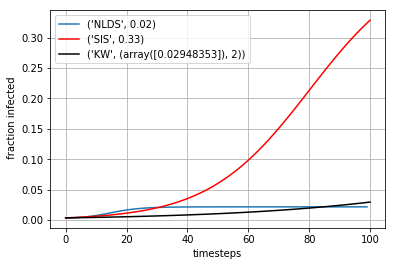

In [1063]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t_1/len(gnow.nodes()),label=("NLDS",round(max(t_1/len(gnow.nodes())),2)))
my_SIS(gnow,beta,gamma,t,ax1)
my_KW(gnow,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [678]:
# eigen=np.linalg.eigvals(A5)
# max(eigen)

# Random Vaccination

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

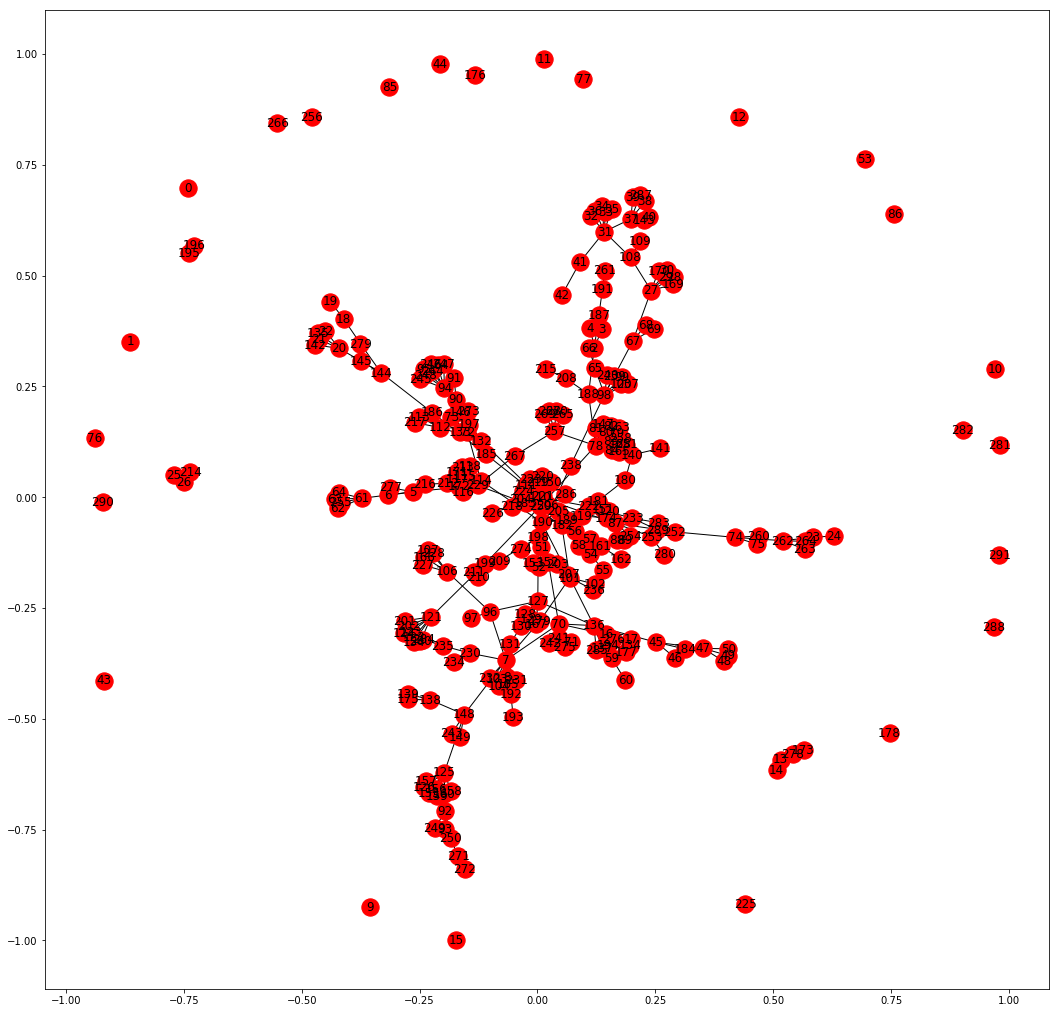

<Figure size 1296x1296 with 0 Axes>

In [1065]:
random_nodes = sample(list(G.nodes()), int(0.1*len(G.nodes())))
random_nodes
g2=G.copy()
g2.remove_nodes_from(random_nodes)
A_ran=nx.to_numpy_matrix(g2)
g2=nx.from_numpy_matrix(A_ran)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g2)
nx.draw_networkx(g2)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [1069]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A_ran))
init[96] = 1
t8,p1 = trial(A_ran,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

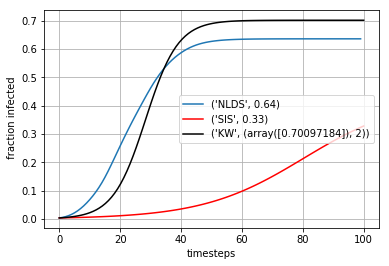

In [1070]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t8/len(g2.nodes()),label=("NLDS",round(max(t8/len(g2.nodes())),2)))
my_SIS(g2,beta,gamma,t,ax1)
my_KW(g2,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Highest betweenness centrality

In [1073]:
import operator
def btwn(g):
    d=nx.betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 
    return e[:int(0.1*len(g.nodes()))]

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

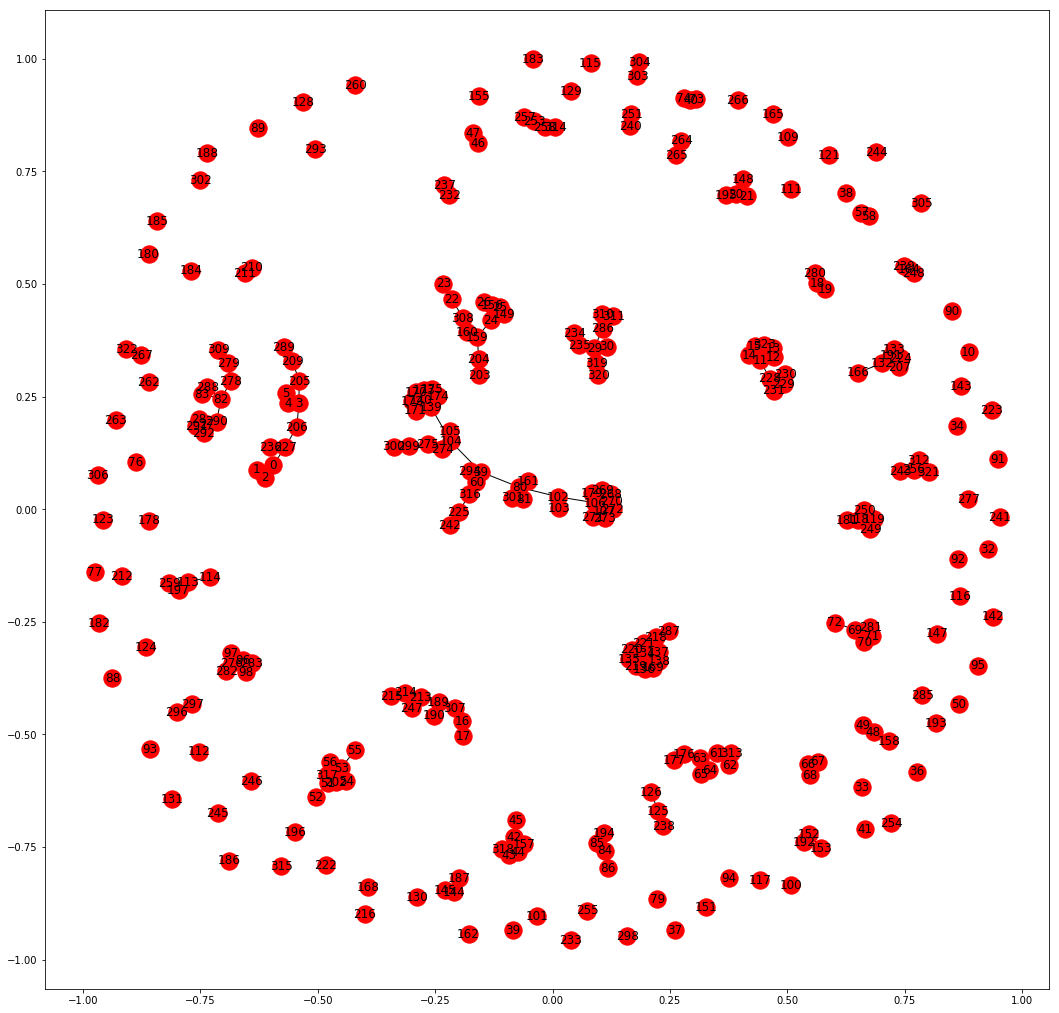

In [1074]:

g5=G.copy()
g5.remove_nodes_from(btwn(g5))
A8=nx.to_numpy_matrix(g5)
gnow1=nx.from_numpy_matrix(A8)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g5)
nx.draw_networkx(g5)
#plt.title(title)
plt.show()


In [684]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A8))
init[200] = 1
t11,p1 = trial(A8,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

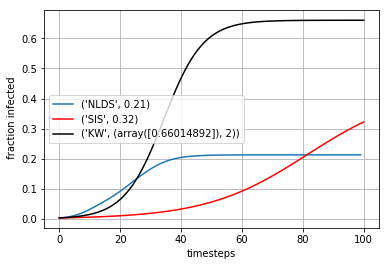

In [685]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t11/len(g5.nodes()),label=("NLDS",round(max(t11/len(g5.nodes())),2)))
my_SIS(g5,beta,gamma,t,ax1)
my_KW(g5,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Eigen 

In [1079]:
import operator
def eigen_centrality(g):
    d=nx.eigenvector_centrality_numpy(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 
    return e[:int(0.1*len(g.nodes()))]

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

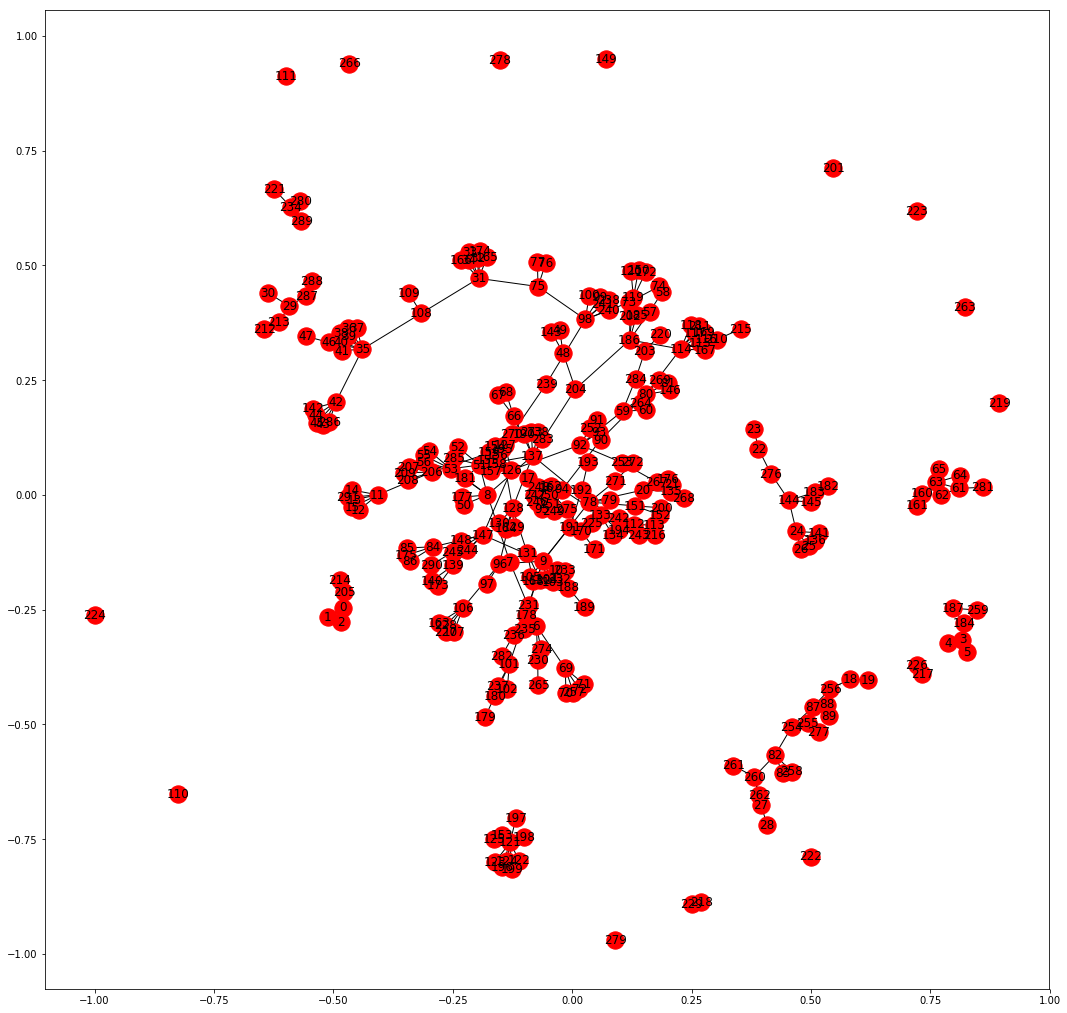

<Figure size 1296x1296 with 0 Axes>

In [1080]:
g7=G.copy()
g7.remove_nodes_from(eigen_centrality(G))
A10=nx.to_numpy_matrix(g7)
g7=nx.from_numpy_matrix(A10)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g7)
nx.draw_networkx(g7)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [1081]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A10))
init[10] = 1
t13,p1 = trial(A10,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

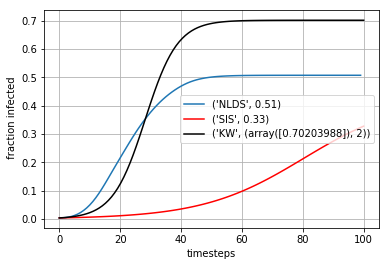

In [1082]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t13/len(g7.nodes()),label=("NLDS",round(max(t13/len(g7.nodes())),2)))
my_SIS(g7,beta,gamma,t,ax1)
my_KW(g7,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

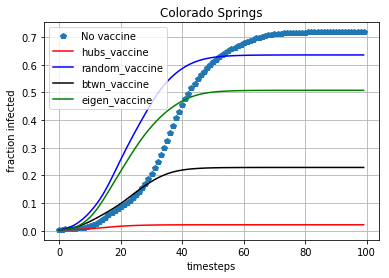

In [1083]:
# |.,  plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t4/len(G.nodes()),'p',label=("No vaccine"))
plt.plot(range(m),t_1/len(gnow.nodes()),'r',label=("hubs_vaccine"))
plt.plot(range(m),t8/len(g2.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t11/len(g5.nodes()),'k',label=("btwn_vaccine"))
plt.plot(range(m),t13/len(g7.nodes()),'g',label=("eigen_vaccine"))#my_SIS(D3,beta,gamma,t,ax1)
#my_KW(D3,beta,gamma,t,ax1)
plt.grid()
plt.title("Colorado Springs")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [691]:
print(max(np.linalg.eigvals(A5)))# hubs
print(max(np.linalg.eigvals(A_ran)))#rand
print(max(np.linalg.eigvals(A8)))#bet
print(max(np.linalg.eigvals(A10)))#eigen

(3.7850058522897365+0j)
(4.840333551597269+0j)
(3.784384337524698+0j)
(4.846677903530972+0j)


### Dolphin 

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

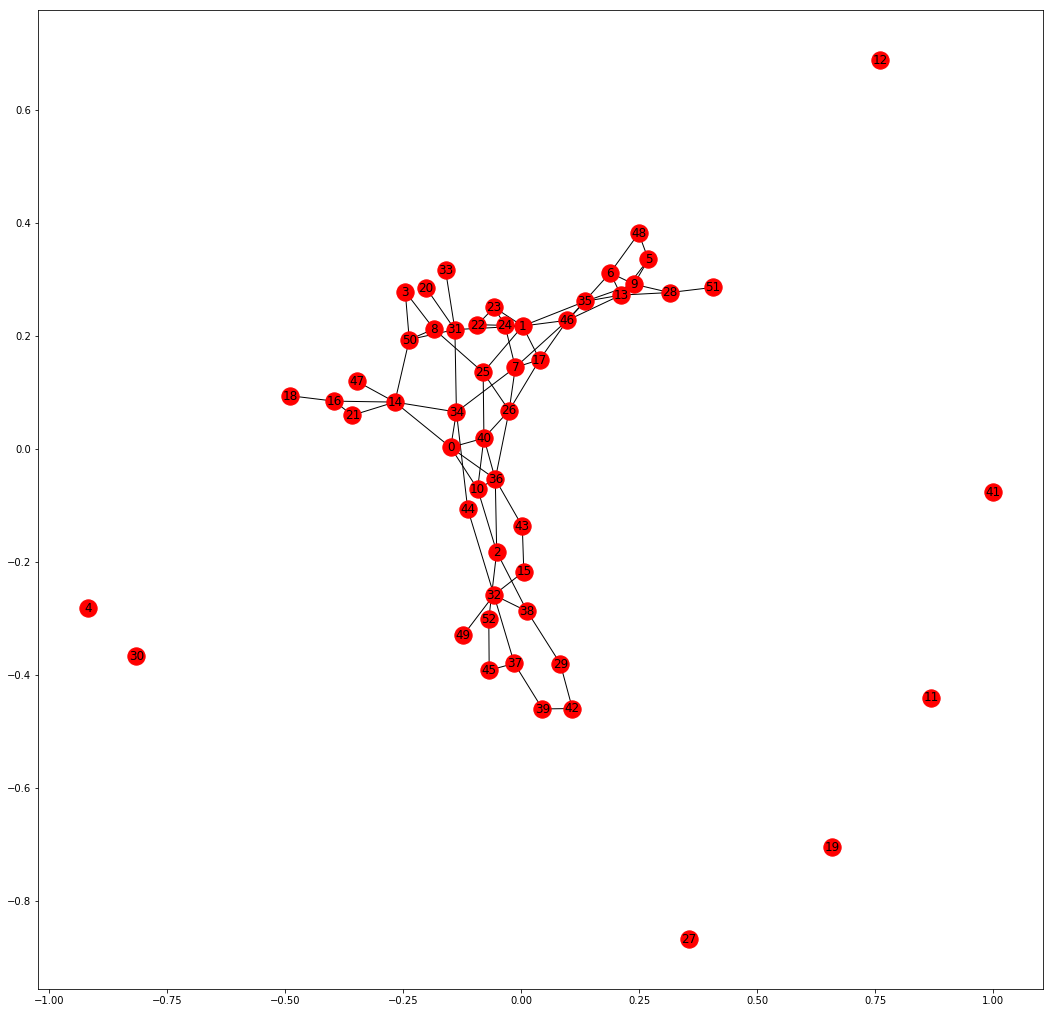

<Figure size 1296x1296 with 0 Axes>

In [1084]:
g3=Z.copy()
g3.remove_nodes_from(visualisation(Z))
A6=nx.to_numpy_matrix(g3)
g3=nx.from_numpy_matrix(A6)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g3)
nx.draw_networkx(g3)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

# Vaccinating the hubs

In [1087]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A6))
init[0] = 1
t9,p1 = trial(A6,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

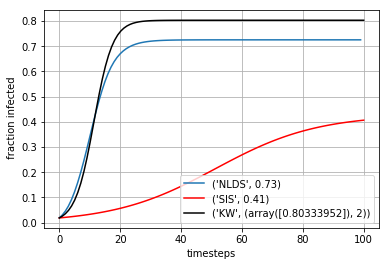

In [1088]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t9/len(g3.nodes()),label=("NLDS",round(max(t9/len(g3.nodes())),2)))
my_SIS(g3,beta,gamma,t,ax1)
my_KW(g3,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [695]:
def rand_nodes(g):
    return sample(list(g.nodes()), 10)

# Random Vaccination

[45, 61, 9, 47, 42, 51, 25, 20, 2, 37]


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

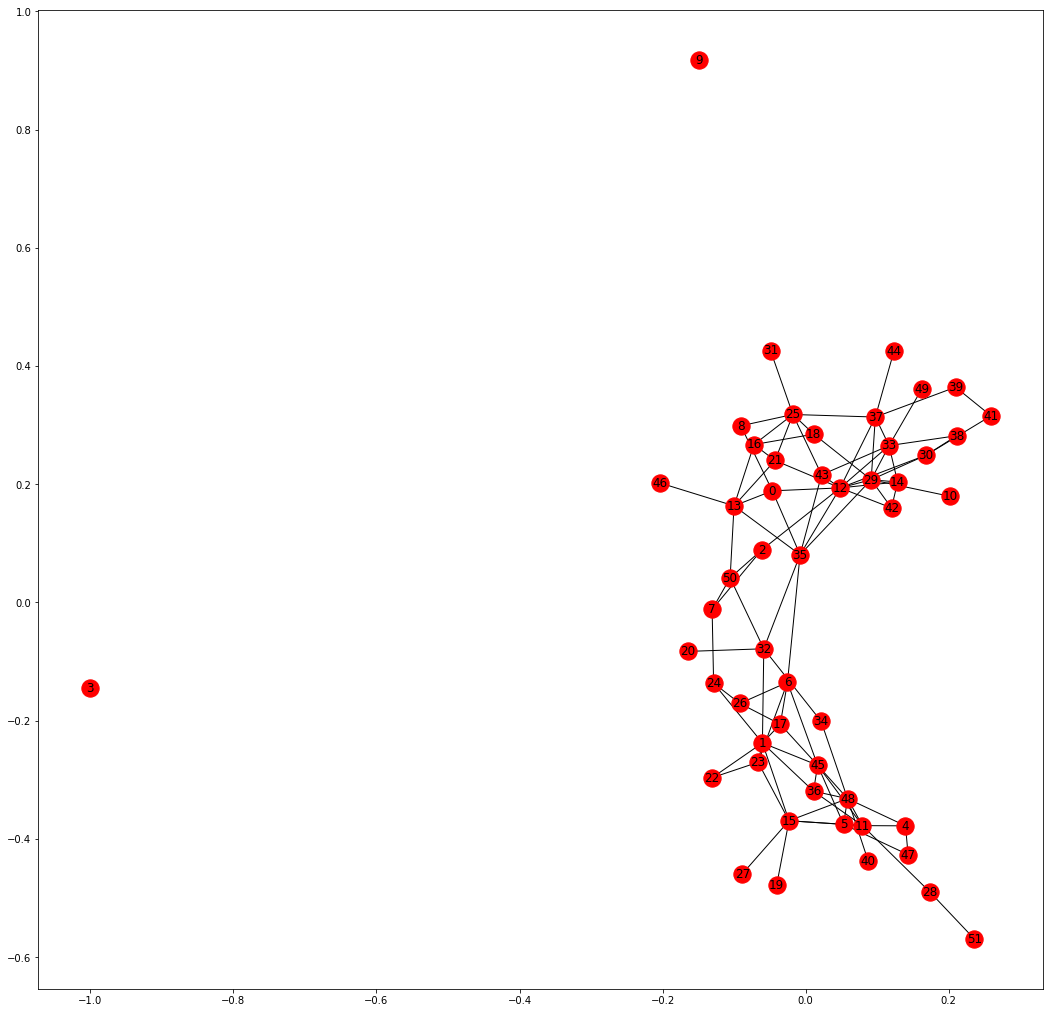

<Figure size 1296x1296 with 0 Axes>

In [696]:
random_nodes1 = sample(list(Z.nodes()), 10)
print(random_nodes1)
g4=Z.copy()
g4.remove_nodes_from(random_nodes1)
A7=nx.to_numpy_matrix(g4)
g4=nx.from_numpy_matrix(A7)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g4)
nx.draw_networkx(g4)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [1089]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A7))
init[0] = 1
t10,p1 = trial(A7,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

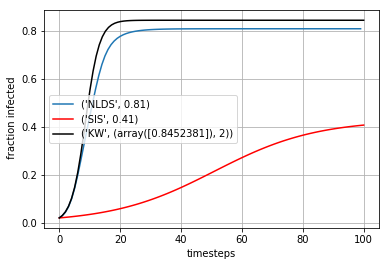

In [1090]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t10/len(g4.nodes()),label=("NLDS",round(max(t10/len(g4.nodes())),2)))
my_SIS(g4,beta,gamma,t,ax1)
my_KW(g4,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Highest betweenness centrality

In [1093]:
btwn(Z)

[36, 1, 40, 37, 7, 17]

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

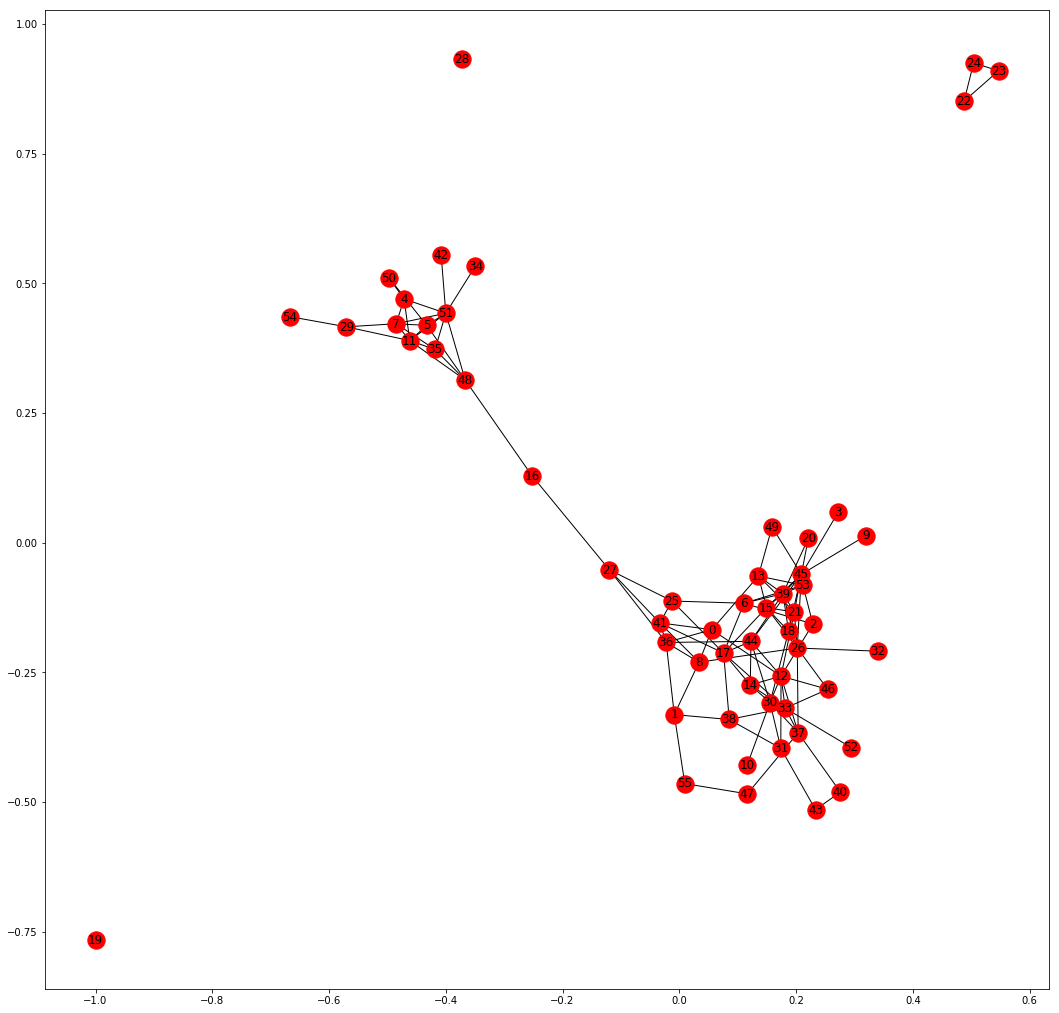

In [1094]:
g6=Z.copy()
g6.remove_nodes_from(btwn(Z))
A9=nx.to_numpy_matrix(g6)
g6=nx.from_numpy_matrix(A9)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g6)
nx.draw_networkx(g6)
#plt.title(title)
plt.show()


In [701]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A9))
init[0] = 1
t12,p1 = trial(A9,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

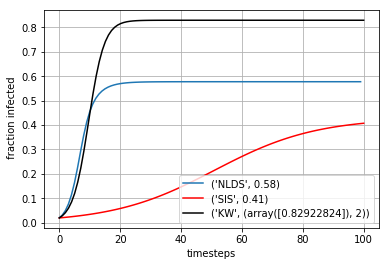

In [702]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t12/len(g6.nodes()),label=("NLDS",round(max(t12/len(g6.nodes())),2)))
my_SIS(g6,beta,gamma,t,ax1)
my_KW(g6,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# eigen

In [703]:
type(nx.eigenvector_centrality_numpy(G))

dict

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

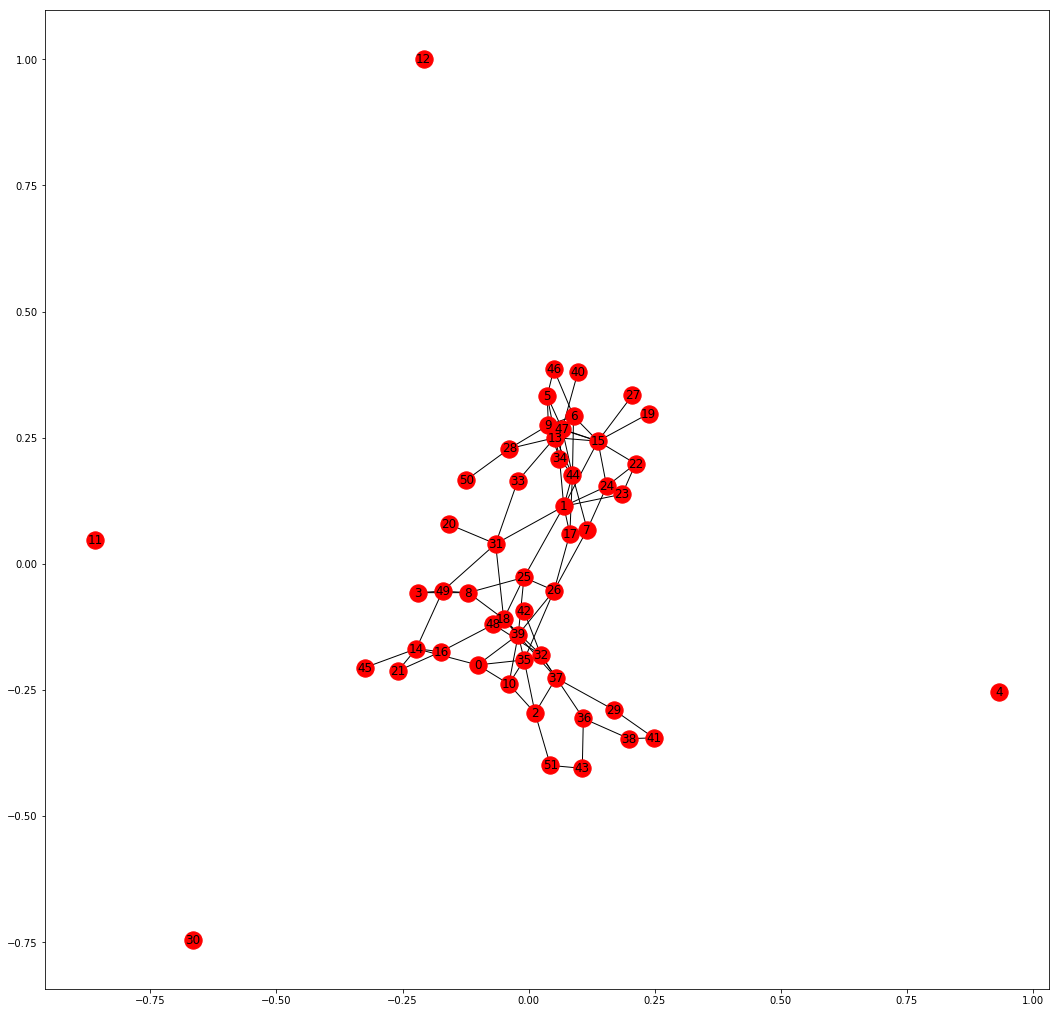

<Figure size 1296x1296 with 0 Axes>

In [704]:
g8=Z.copy()
g8.remove_nodes_from(eigen_centrality(Z))
A11=nx.to_numpy_matrix(g8)
g8=nx.from_numpy_matrix(A11)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g8)
nx.draw_networkx(g8)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [1095]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A11))
init[0] = 1
t14,p1 = trial(A11,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

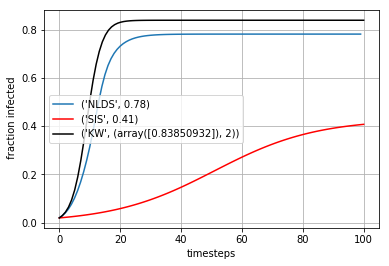

In [1096]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t14/len(g8.nodes()),label=("NLDS",round(max(t14/len(g8.nodes())),2)))
my_SIS(g8,beta,gamma,t,ax1)
my_KW(g8,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

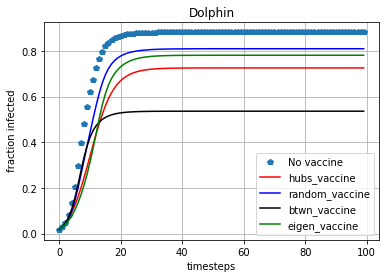

In [1097]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m7),t7/len(Z.nodes()),'p',label=("No vaccine"))
plt.plot(range(m),t9/len(g3.nodes()),'r',label=("hubs_vaccine"))
plt.plot(range(m),t10/len(g4.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t12/len(g6.nodes()),'k',label=("btwn_vaccine"))
plt.plot(range(m),t14/len(g8.nodes()),'g',label=("eigen_vaccine"))#my_SIS(D3,beta,gamma,t,ax1)
#my_KW(D3,beta,gamma,t,ax1)
plt.grid()
plt.title("Dolphin")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [708]:
print(max(np.linalg.eigvals(A6)))# hubs
print(max(np.linalg.eigvals(A7)))#rand
print(max(np.linalg.eigvals(A9)))#bet
print(max(np.linalg.eigvals(A11)))#eigen

4.025334544131631
(5.51088898792195+0j)
(5.561745635159549+0j)
5.942213927271324


# les mis

# Hubs

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

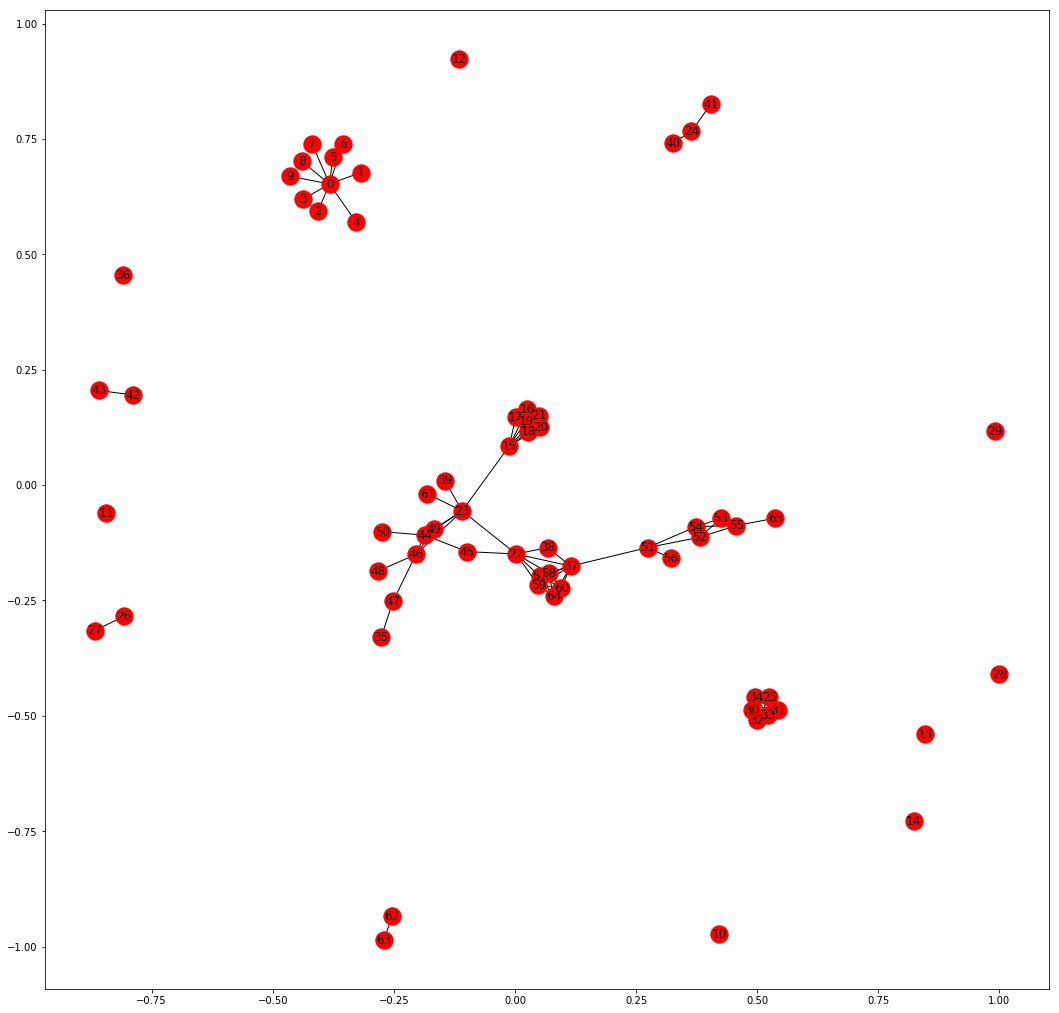

<Figure size 1296x1296 with 0 Axes>

In [709]:
g9=F.copy()
g9.remove_nodes_from(visualisation(F))
A12=nx.to_numpy_matrix(g9)
g9=nx.from_numpy_matrix(A12)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g9)
nx.draw_networkx(g9)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [710]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A12))
init[22] = 1
t15,p1 = trial(A12,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

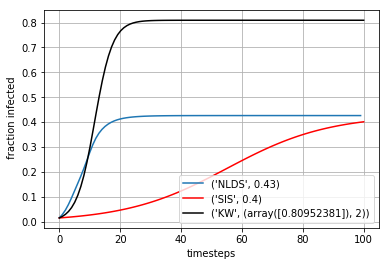

In [711]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t15/len(g9.nodes()),label=("NLDS",round(max(t15/len(g9.nodes())),2)))
my_SIS(g9,beta,gamma,t,ax1)
my_KW(g9,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Random

[15, 38, 72, 40, 18, 67, 70, 74, 14, 17]


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

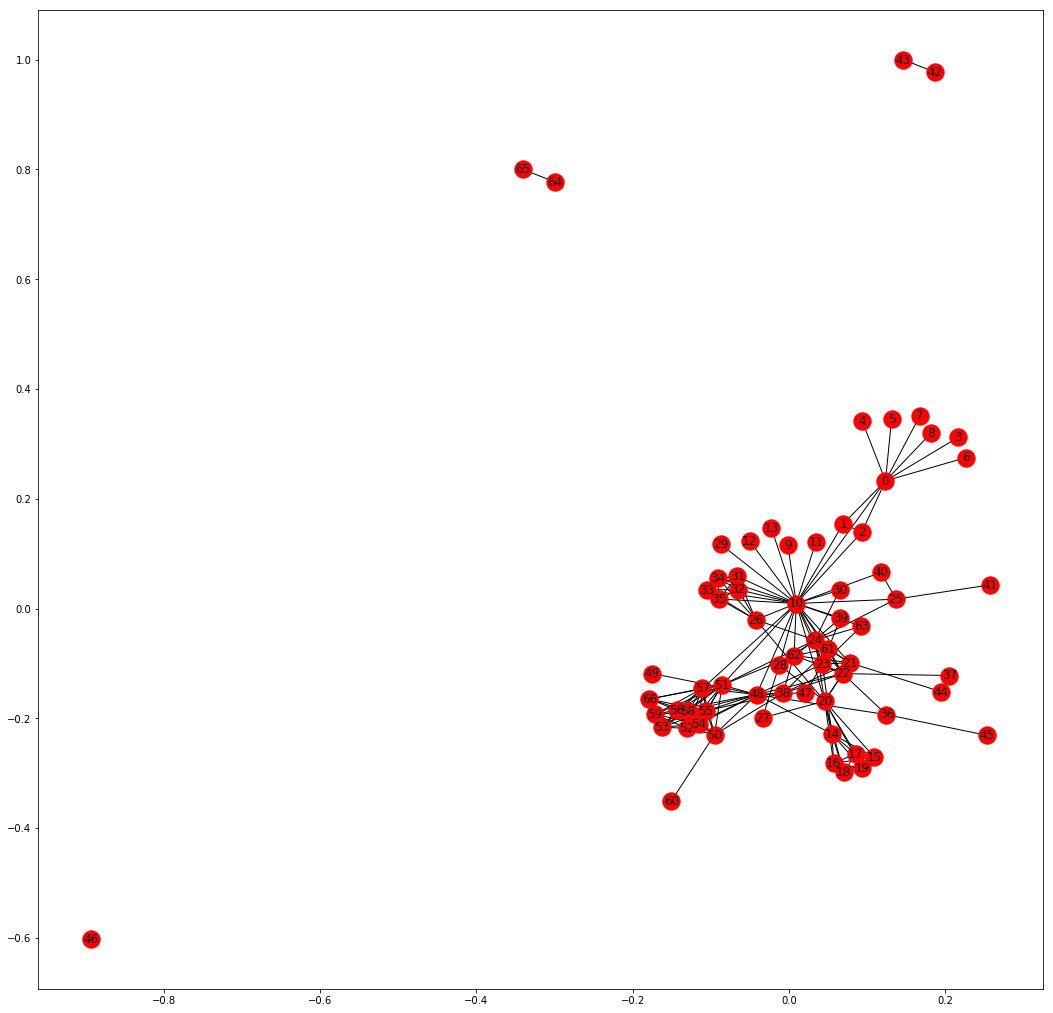

<Figure size 1296x1296 with 0 Axes>

In [712]:
g10=F.copy()
print(rand_nodes(F))
g10.remove_nodes_from(rand_nodes(F))
A13=nx.to_numpy_matrix(g10)
g10=nx.from_numpy_matrix(A13)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g10)
nx.draw_networkx(g10)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [713]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A13))
init[0] = 1
t16,p1 = trial(A13,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

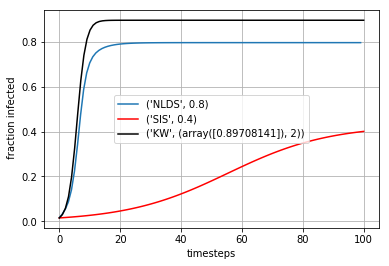

In [714]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t16/len(g10.nodes()),label=("NLDS",round(max(t16/len(g10.nodes())),2)))
my_SIS(g10,beta,gamma,t,ax1)
my_KW(g10,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# betweenness


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

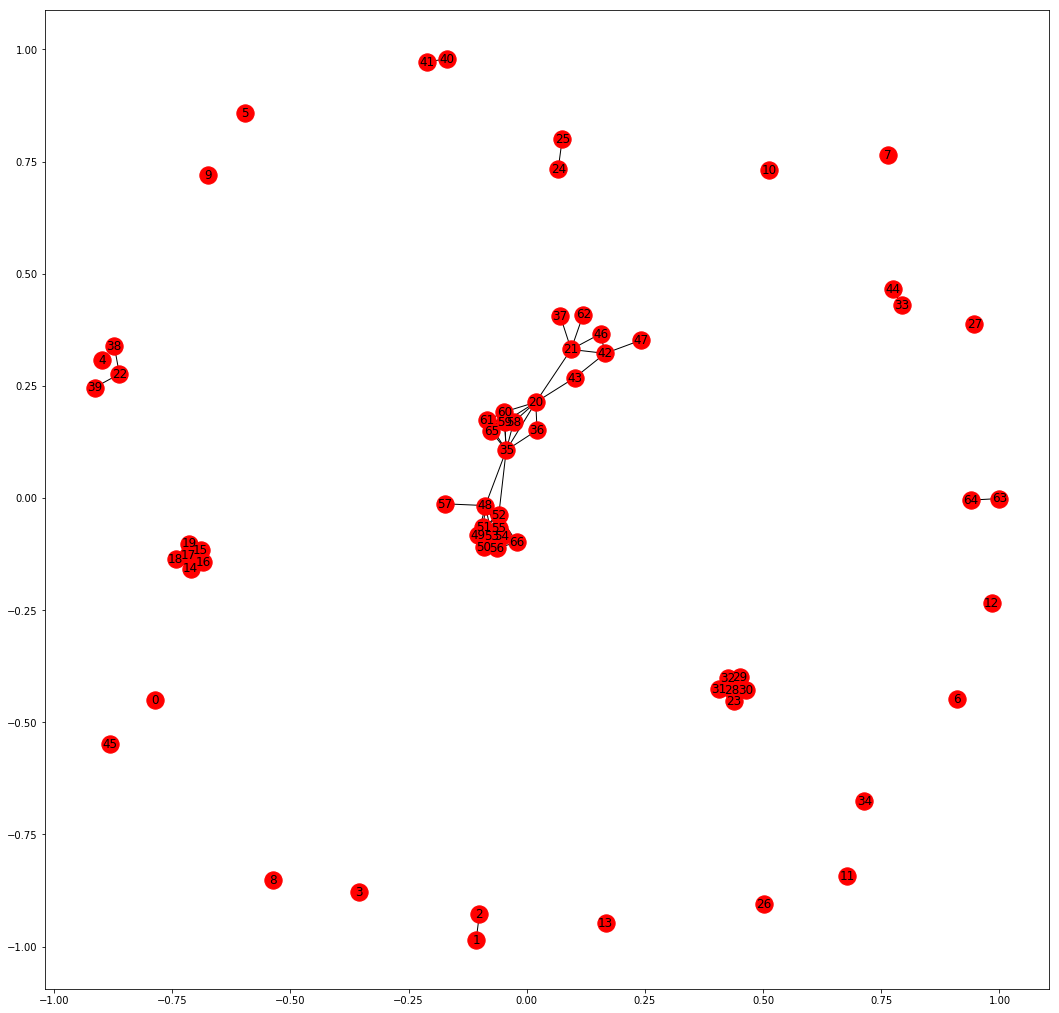

<Figure size 1296x1296 with 0 Axes>

In [715]:
g11=F.copy()
g11.remove_nodes_from(btwn(F))
A14=nx.to_numpy_matrix(g11)
g11=nx.from_numpy_matrix(A14)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g11)
nx.draw_networkx(g11)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [716]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A14))
init[20] = 1
t17,p1 = trial(A14,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

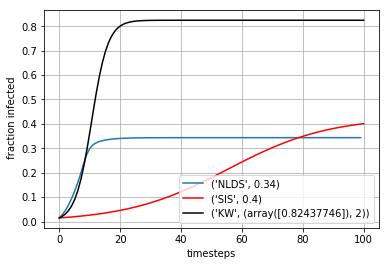

In [717]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t17/len(g11.nodes()),label=("NLDS",round(max(t17/len(g11.nodes())),2)))
my_SIS(g11,beta,gamma,t,ax1)
my_KW(g11,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Eigen

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

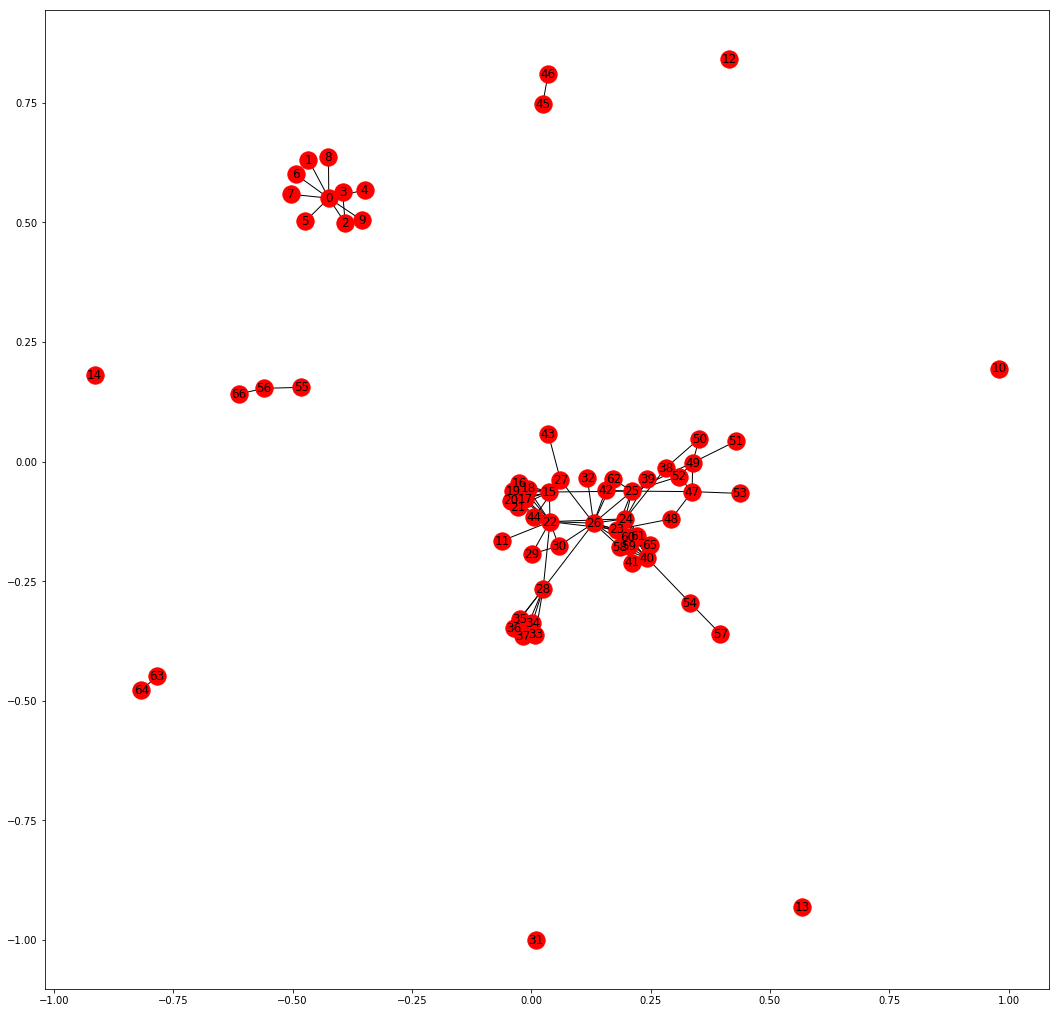

<Figure size 1296x1296 with 0 Axes>

In [718]:
g12=F.copy()
g12.remove_nodes_from(eigen_centrality(F))
A15=nx.to_numpy_matrix(g12)
g12=nx.from_numpy_matrix(A15)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g12)
nx.draw_networkx(g12)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [719]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A15))
init[20] = 1
t18,p1 = trial(A15,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

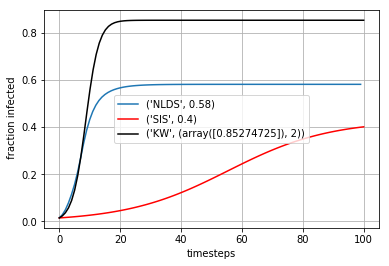

In [720]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t18/len(g12.nodes()),label=("NLDS",round(max(t18/len(g12.nodes())),2)))
my_SIS(g12,beta,gamma,t,ax1)
my_KW(g12,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

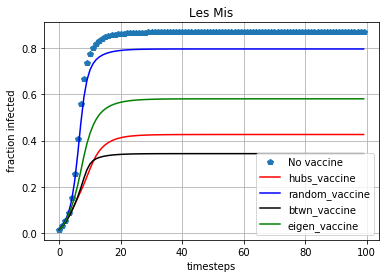

In [799]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m),t8/len(F.nodes()),'p',label=("No vaccine"))
plt.plot(range(m),t15/len(g9.nodes()),'r',label=("hubs_vaccine"))
plt.plot(range(m),t16/len(g10.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t17/len(g11.nodes()),'k',label=("btwn_vaccine"))
plt.plot(range(m),t18/len(g12.nodes()),'g',label=("eigen_vaccine"))#my_SIS(D3,beta,gamma,t,ax1)
#my_KW(D3,beta,gamma,t,ax1)
plt.grid()
plt.title("Les Mis")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [722]:
print(max(np.linalg.eigvals(P1)),'no vaccination')# 
print(max(np.linalg.eigvals(A12)),'hubs_vaccination')# hubs
print(max(np.linalg.eigvals(A13)),'random_vaccination')#rand
print(max(np.linalg.eigvals(A14)),'btw_vaccination')#bet
print(max(np.linalg.eigvals(A15)),'eigen_vaccination')#eigen

(12.005754950137824+0j) no vaccination
6.03283559899888 hubs
(10.267961595667177+0j) random
8.051221398741646 btw
8.02794933829373 eigen


# Drugs 

## Hubs

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

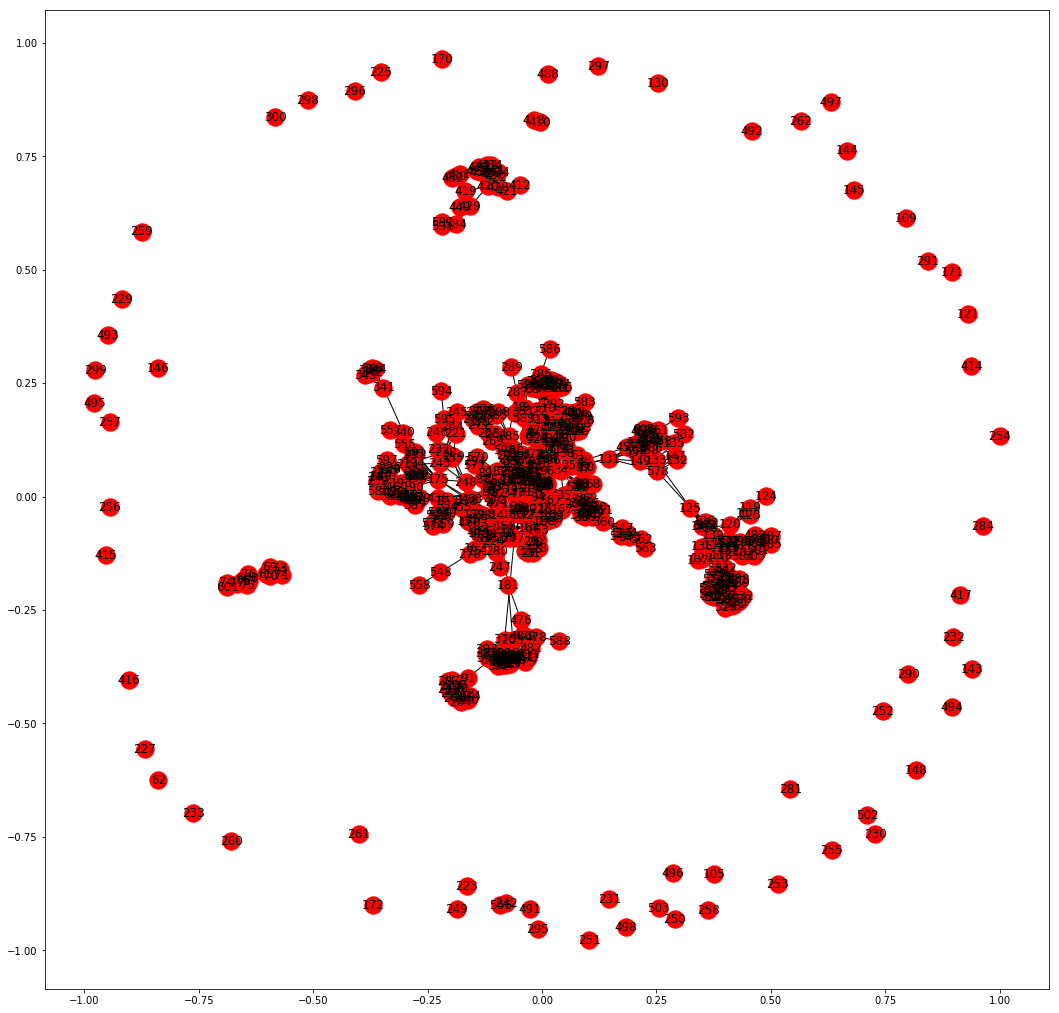

<Figure size 1296x1296 with 0 Axes>

In [723]:
g_D=D.copy()
g_D.remove_nodes_from(visualisation(D))
A16=nx.to_numpy_matrix(g_D)
g_D=nx.from_numpy_matrix(A16)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(g_D)
nx.draw_networkx(g_D)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [724]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A16))
init[0] = 1
t19,p1 = trial(A16,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

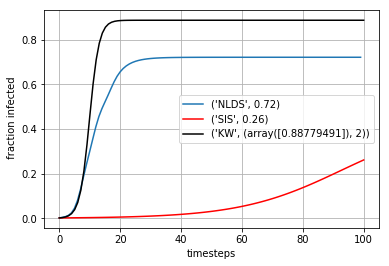

In [725]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t19/len(g_D.nodes()),label=("NLDS",round(max(t19/len(g_D.nodes())),2)))
my_SIS(g_D,beta,gamma,t,ax1)
my_KW(g_D,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Random

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

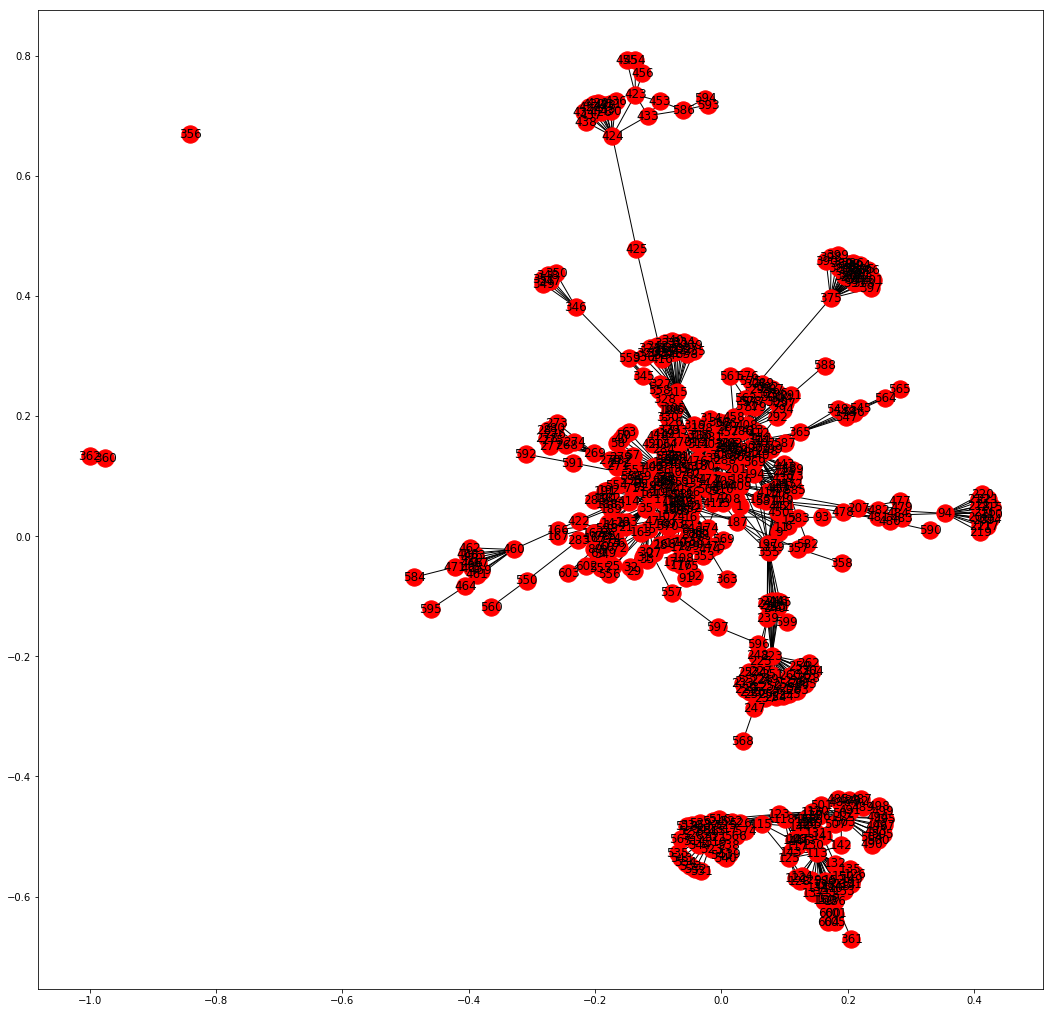

<Figure size 1296x1296 with 0 Axes>

In [726]:
D1=D.copy()
D1.remove_nodes_from(rand_nodes(D1))
A17=nx.to_numpy_matrix(D1)
D1=nx.from_numpy_matrix(A17)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(D1)
nx.draw_networkx(D1)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [727]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A17))
init[0] = 1
t20,p1 = trial(A17,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

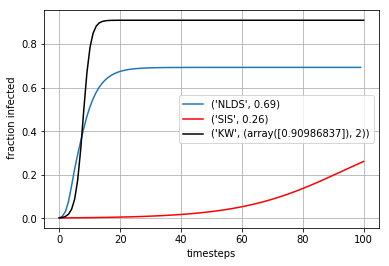

In [728]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t20/len(D1.nodes()),label=("NLDS",round(max(t20/len(D1.nodes())),2)))
my_SIS(D1,beta,gamma,t,ax1)
my_KW(D1,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Betweeness

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

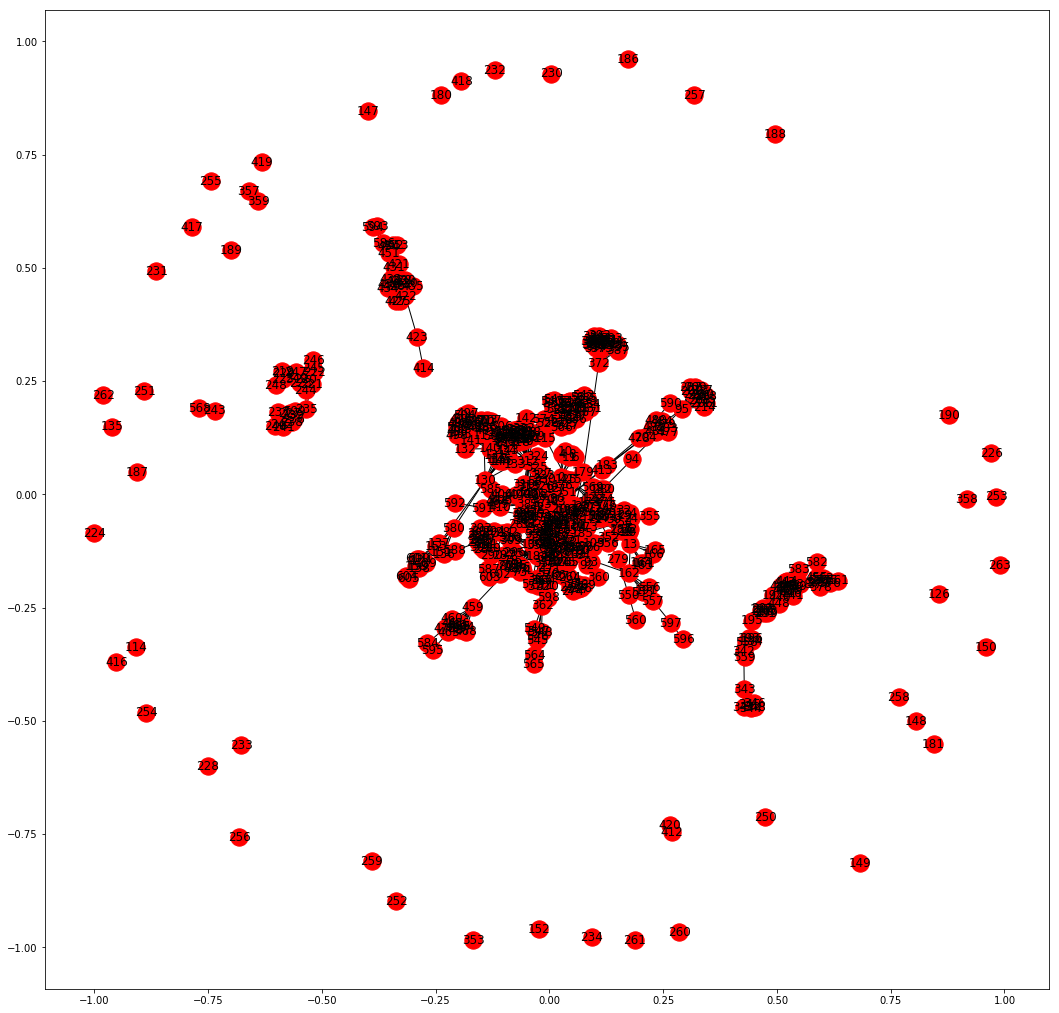

<Figure size 1296x1296 with 0 Axes>

In [729]:
D2=D.copy()
D2.remove_nodes_from(btwn(D2))
A18=nx.to_numpy_matrix(D2)
D2=nx.from_numpy_matrix(A18)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(D2)
nx.draw_networkx(D2)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [730]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A18))
init[279] = 1
t21,p1 = trial(A18,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

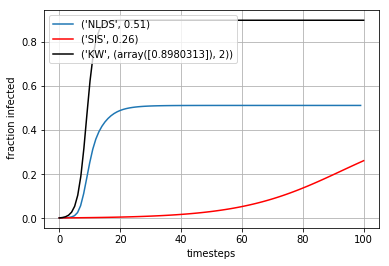

In [731]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t21/len(D2.nodes()),label=("NLDS",round(max(t21/len(D2.nodes())),2)))
my_SIS(D2,beta,gamma,t,ax1)
my_KW(D2,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Eigen

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

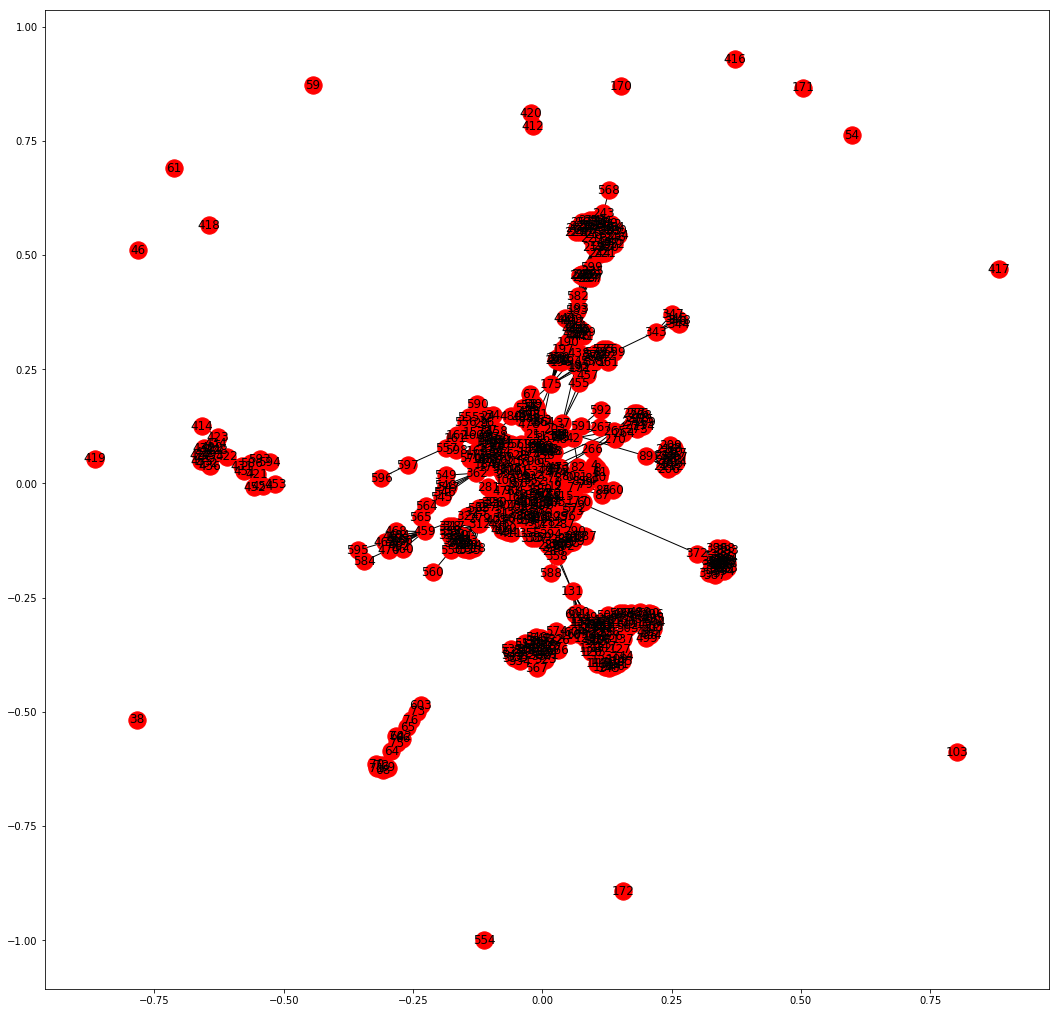

<Figure size 1296x1296 with 0 Axes>

In [732]:
D3=D.copy()
D3.remove_nodes_from(eigen_centrality(D3))
A19=nx.to_numpy_matrix(D3)
D3=nx.from_numpy_matrix(A19)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(D3)
nx.draw_networkx(D3)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [733]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(A19))
init[89] = 1
t22,p1 = trial(A19,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

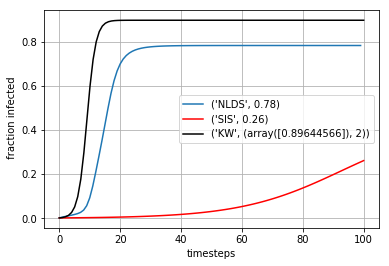

In [734]:
beta=0.14
gamma=0.08
t=np.linspace(0,100,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t22/len(D3.nodes()),label=("NLDS",round(max(t22/len(D3.nodes())),2)))
my_SIS(D3,beta,gamma,t,ax1)
my_KW(D3,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

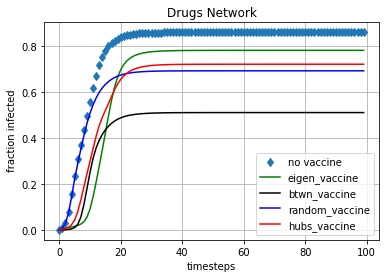

In [798]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m5),t5/len(D.nodes()),"d",label=("no vaccine"))
plt.plot(range(m),t22/len(D3.nodes()),'g',label=("eigen_vaccine"))
plt.plot(range(m),t21/len(D2.nodes()),'k',label=("btwn_vaccine"))
plt.plot(range(m),t20/len(D1.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t19/len(g_D.nodes()),'r',label=("hubs_vaccine"))#my_SIS(D3,beta,gamma,t,ax1)
#my_KW(D3,beta,gamma,t,ax1)
plt.grid()
plt.title("Drugs Network")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [736]:
print(max(np.linalg.eigvals(A3)),'original')
print(max(np.linalg.eigvals(A16)),'hubs')# hubs
print(max(np.linalg.eigvals(A17)),'random')#rand
print(max(np.linalg.eigvals(A18)),'betweenness')#bet
print(max(np.linalg.eigvals(A19)),'eigen')#eigen

(18.009862213280837+0j) original
(12.687794187004853+0j) hubs
(17.496076390552126+0j) random
(16.04638858871006+0j) betweenness
(13.56920467099687+0j) eigen


# EIGENVALUES AND EPIDEMIC THRESHOLDS

# Colorado Springs

In [1138]:
print(max(np.linalg.eigvals(A)))

(4.876695538598261+0j)


In [1137]:
(.12/0.8)*5

0.75

$s=\frac{\beta}{\delta}\lambda_{1,A}$

In [739]:
s=(.01/.4)*max(np.linalg.eigvals(A))
s

(0.1219173884649565+0j)

In [1140]:
#s=(8.534217192546958+0j)
m=20
gamma=.08
beta=.14
init = np.zeros(len(A))
init[:] = 1
t23,p1 = trial(A,gamma,beta,m,init)

In [1141]:
# s= 0.1219173884649565
m=20
gamma=.4
beta=.01
init = np.zeros(len(A))
init[:] = 1
t24,p1 = trial(A,gamma,beta,m,init)


In [1146]:
#s=0.7315043307897391+0j
m=20
gamma=.8
beta=.12
init = np.zeros(len(A))
init[:] = 1
t25,p1 = trial(A,gamma,beta,m,init)


<Figure size 432x288 with 0 Axes>

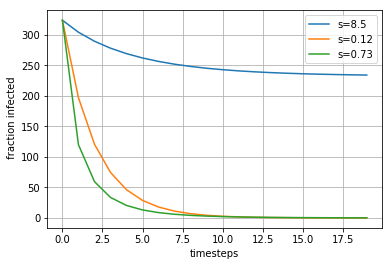

In [1147]:
beta=0.14
gamma=0.08
t=np.linspace(0,20,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t23,label=('s=8.5'))
plt.plot(range(m),t24,label=('s=0.12'))
plt.plot(range(m),t25,label=('s=0.73'))
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# EDGES

In [744]:
def distancing_hubs(g):    
    b=g.copy()
    p=nx.to_numpy_matrix(g)
    
    for i in visualisation(g):
        for j in range(len(p)):
            if p[i,j]==1:
                try:
                    b.remove_edge(i,j)
                except:
                    pass
    c=nx.to_numpy_matrix(b)
    b=nx.from_numpy_matrix(c)
#    
    return c

In [745]:
def graph_hub_eg_removed(g):
    f=nx.from_numpy_matrix(distancing_hubs(g))
    plt.clf()            
    plt.figure(figsize=(18,18))

    a=nx.draw_networkx(f)
    plt.axis('off')
    plt.show()
   
    return a

In [838]:
def hub_eg_removed(g):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(distancing_hubs(g)))
    init[0] = 1
    t,p1 = trial(distancing_hubs(g),gamma,beta,m,init)
    
    a=plt.plot(range(m),t/len(distancing_hubs(g)),'purple',label='hubs_social_distance')
   # b=plt.legend()
    return a

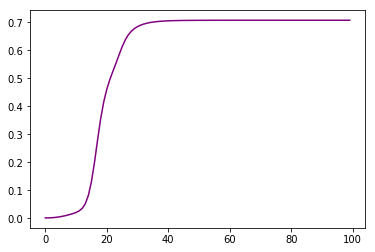

In [899]:
 hub_eg_removed(D)

# Random edges

In [748]:
def rand_eg(g):
    a=sample(list(g.edges()), 10)
    D=g.copy()
    D.remove_edges_from(a)
    A=nx.to_numpy_matrix(D)
    D=nx.from_numpy_matrix(A)

    return A

In [749]:
def graph_rand_eg_removed(g):
    f=nx.from_numpy_matrix(rand_eg(g))
    plt.clf()            
    plt.figure(figsize=(18,18))

    a=nx.draw_networkx(f)
    plt.axis('off')
    plt.show()
    return a

In [847]:
def random_eg_removed(g,ax1):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(rand_eg(g)))
    init[6] = 1
    t,p1 = trial(rand_eg(g),gamma,beta,m,init)

    a=ax1.plot(range(m),t/len(rand_eg(g)),'gold',label="random_social_distancing")
    #b=plt.legend()
    return a

# Edge Betweenness

In [1133]:
def max_edge_btwn(g):
    d=nx.edge_betweenness_centrality(g)
    sorted_tuples = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
    sorted_dict = {k: v for k, v in sorted_tuples}

    e=list(sorted_dict.keys()) 
    #return e[:10]
    t=e[:int(.1*len(g.edges()))]
    D=g.copy()
    D.remove_edges_from(t)
    A=nx.to_numpy_matrix(D)
    D=nx.from_numpy_matrix(A)

    return A

In [1134]:
def graph_max_edge_btwn_removed(g):
    f=nx.from_numpy_matrix(max_edge_btwn(g))
    plt.clf()            
    plt.figure(figsize=(18,18))

    a=nx.draw_networkx(f)
    plt.axis('off')
    plt.show()
    return a

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

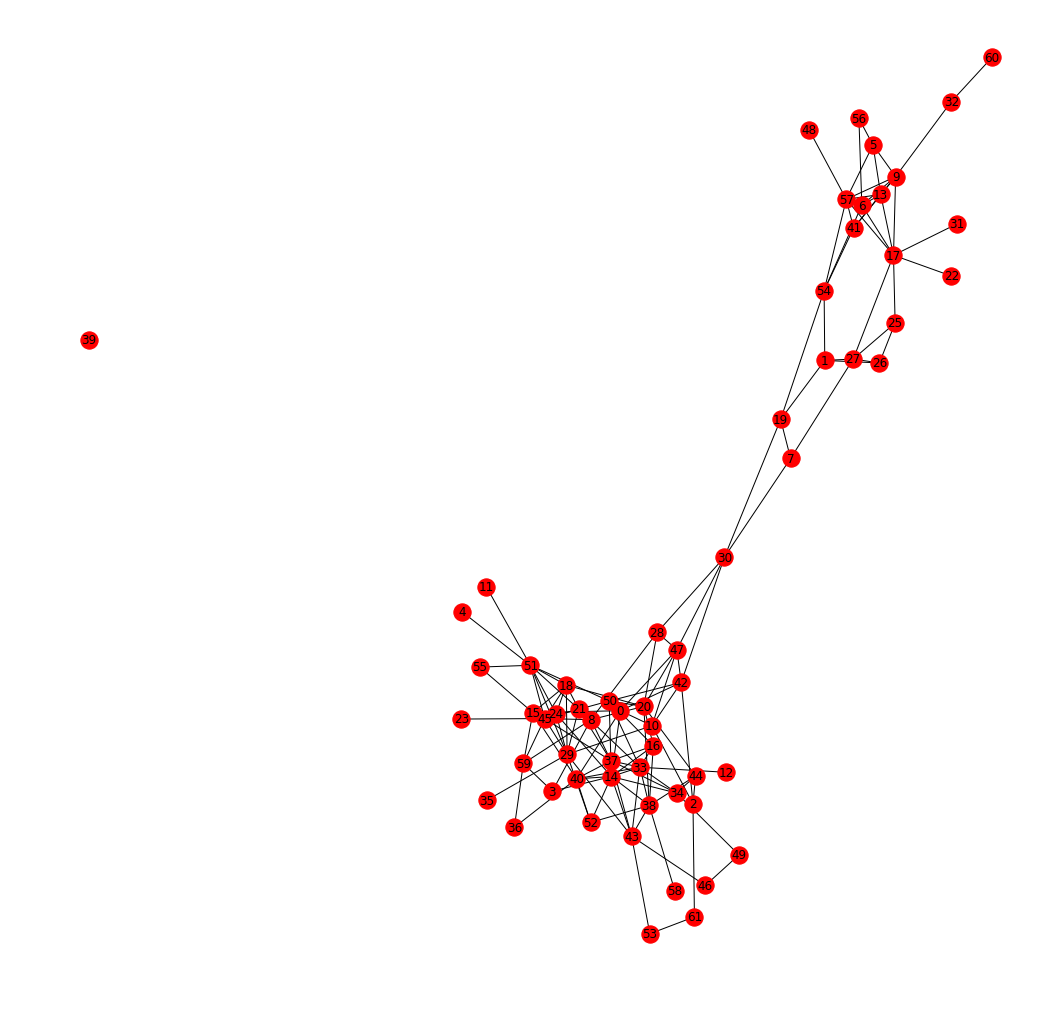

In [1135]:
graph_max_edge_btwn_removed(Z)

In [841]:
def betweenness(g,ax1):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(max_edge_btwn((g))))
    init[0] = 1
    t,p1 = trial(max_edge_btwn(g),gamma,beta,m,init)
    
    a=ax1.plot(range(m),t/len(max_edge_btwn(g)),'c',label="betweenness_social_distancing")
    #b=plt.legend()
    return a

# Colorado Social distancing measures

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

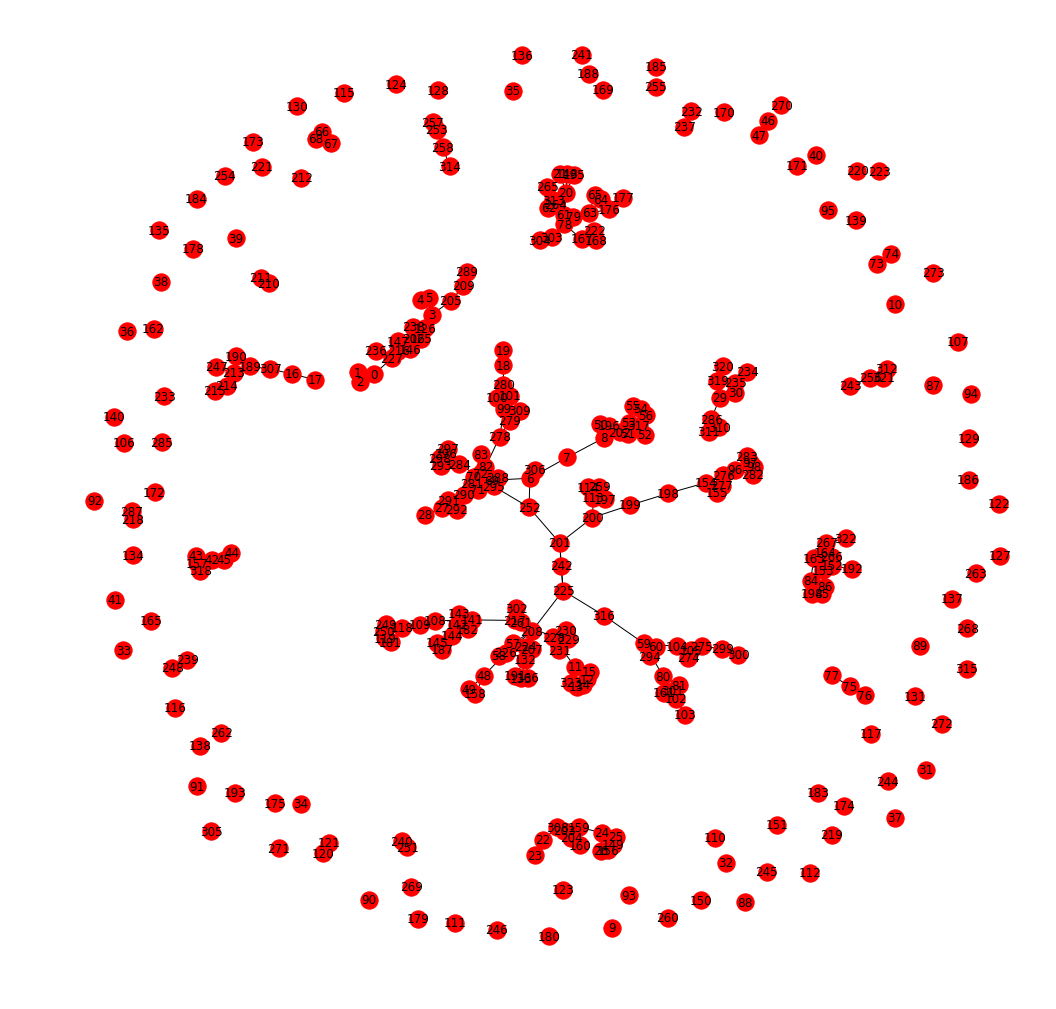

In [755]:
graph_hub_eg_removed(G)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

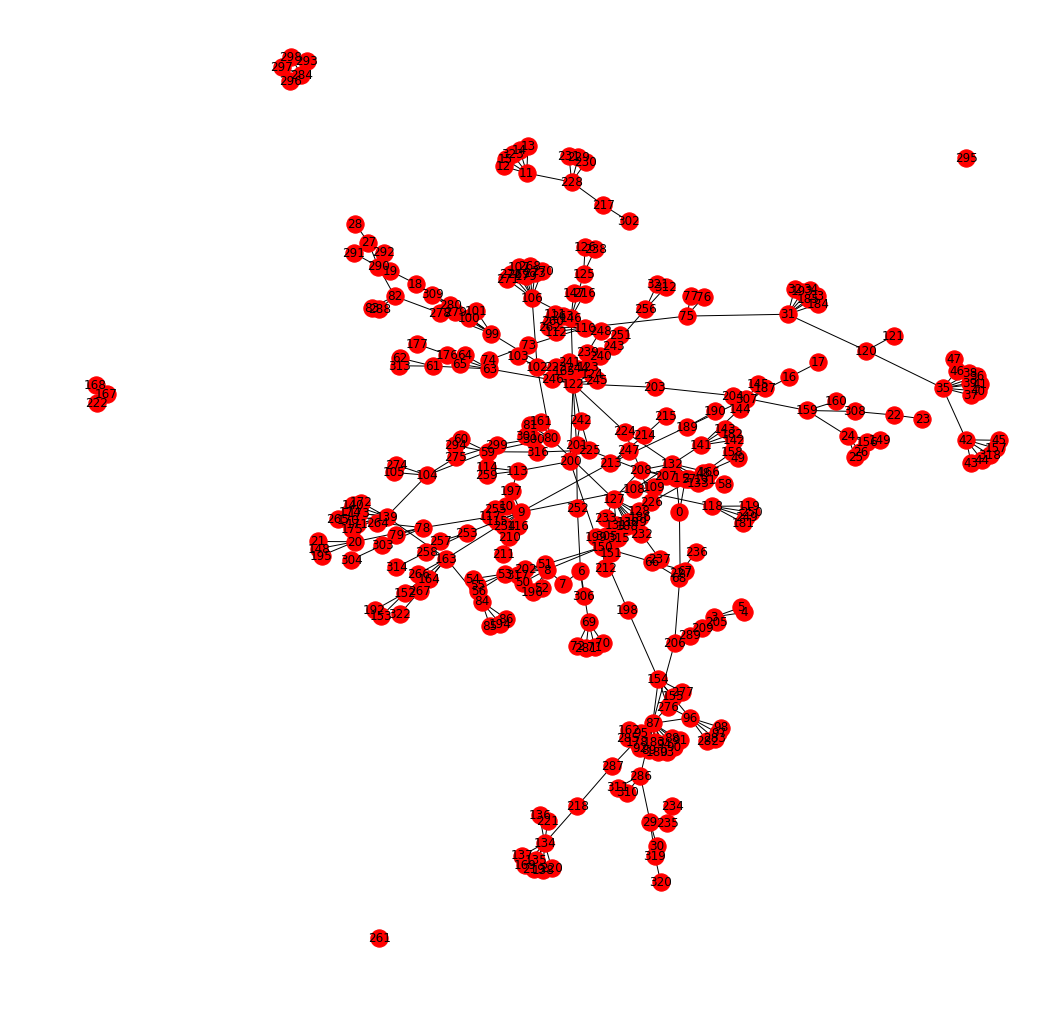

In [756]:
graph_max_edge_btwn_removed(G)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

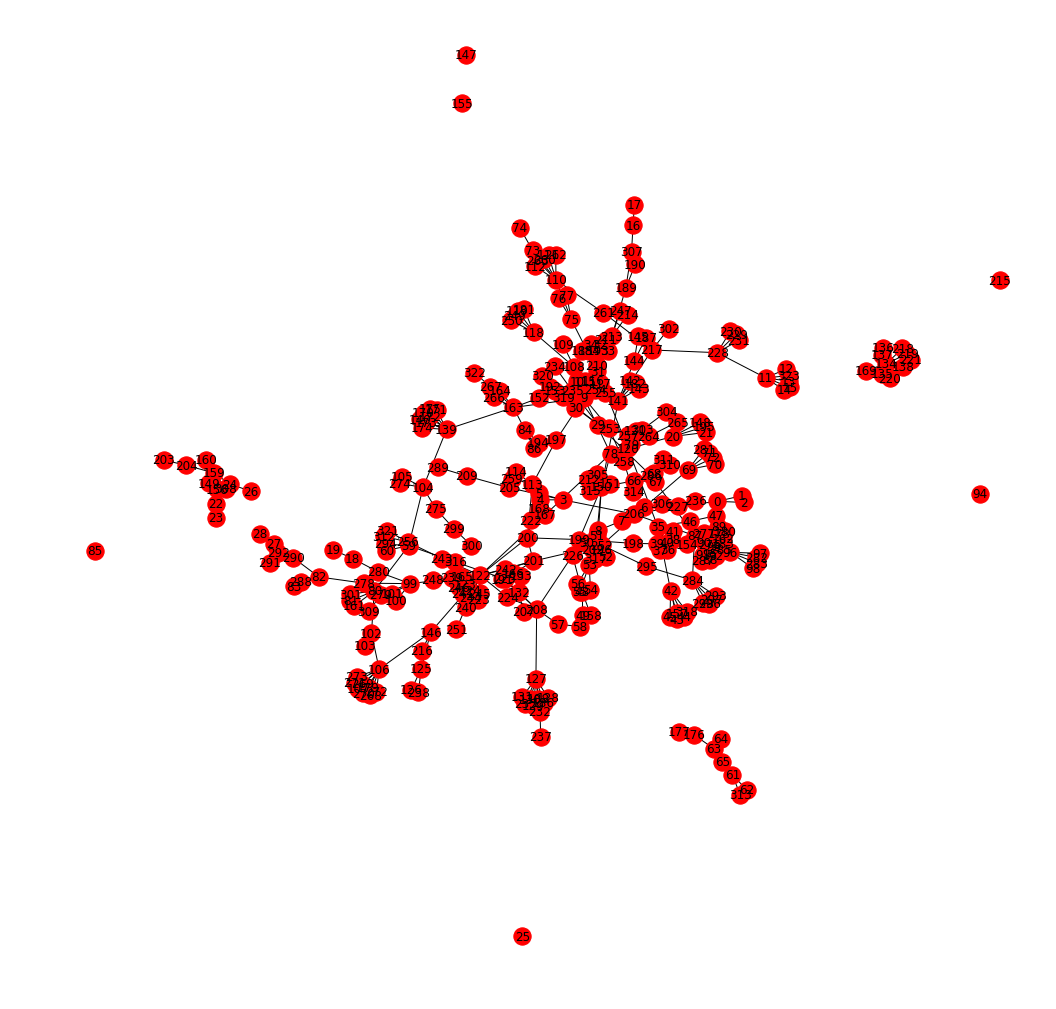

In [757]:
graph_rand_eg_removed(G)

In [842]:
def random_eg_removed(G,ax1):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(rand_eg(G)))
    init[6] = 1
    t,p1 = trial(rand_eg(G),gamma,beta,m,init)

    a=ax1.plot(range(m),t/len(rand_eg(G)),'gold',label="random_social_distancing")
    #b=plt.legend()
    return a

In [843]:
def betweenness(G,ax1):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(max_edge_btwn((G))))
    init[87] = 1
    t,p1 = trial(max_edge_btwn(G),gamma,beta,m,init)
    
    a=ax1.plot(range(m),t/len(max_edge_btwn(G)),'c',label="betweenness_social_distancing")
    #b=plt.legend()
    return a

In [893]:
def hub_eg_removed(G):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(distancing_hubs(G)))
    init[225] = 1
    t,p1 = trial(distancing_hubs(G),gamma,beta,m,init)
    
    a=plt.plot(range(m),t/len(distancing_hubs(G)),'purple',label='hubs_social_distancing')
   # b=plt.legend()
    return a

<Figure size 432x288 with 0 Axes>

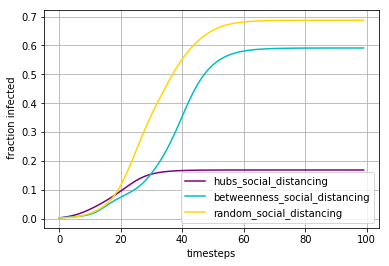

In [894]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
hub_eg_removed(G)
betweenness(G,ax1)
random_eg_removed(G,ax1)

ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Drugs Edge removal

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

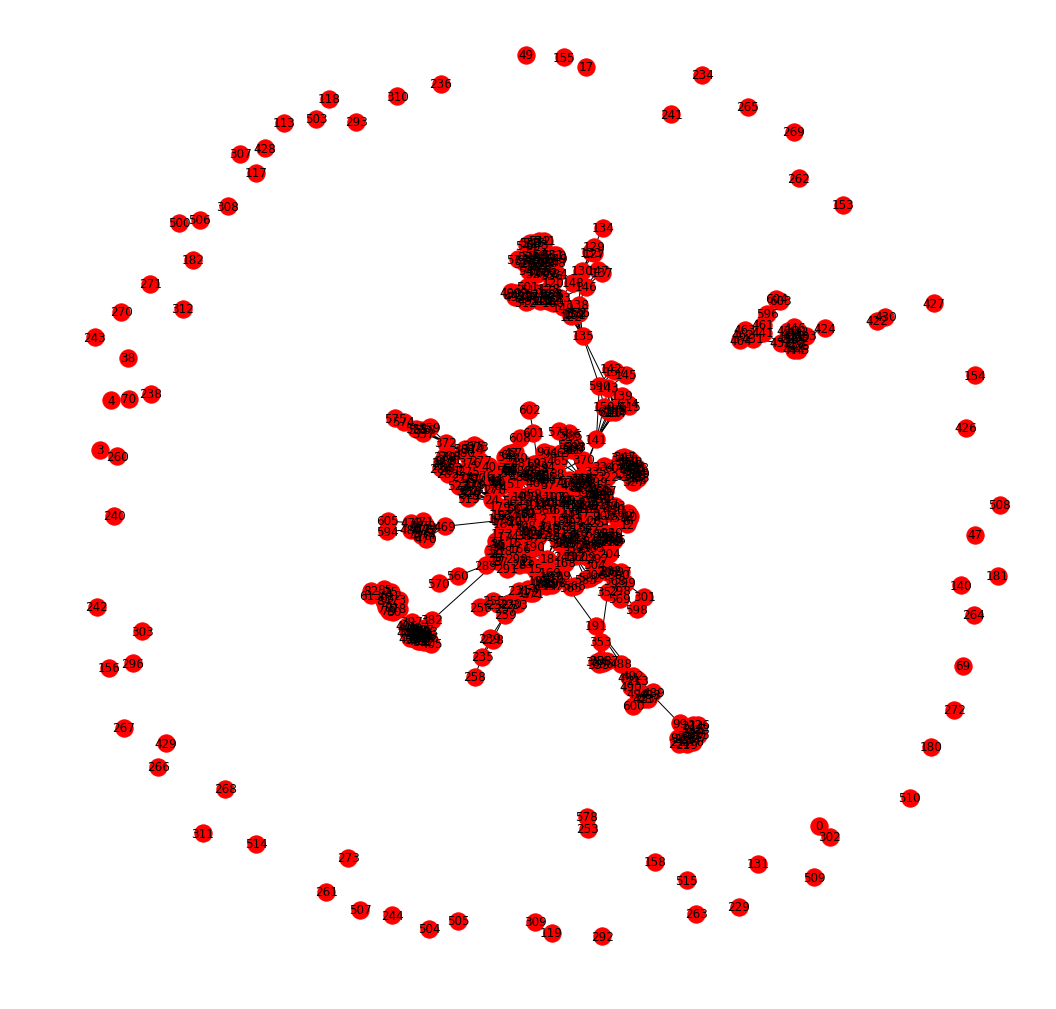

In [762]:
graph_hub_eg_removed(D)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

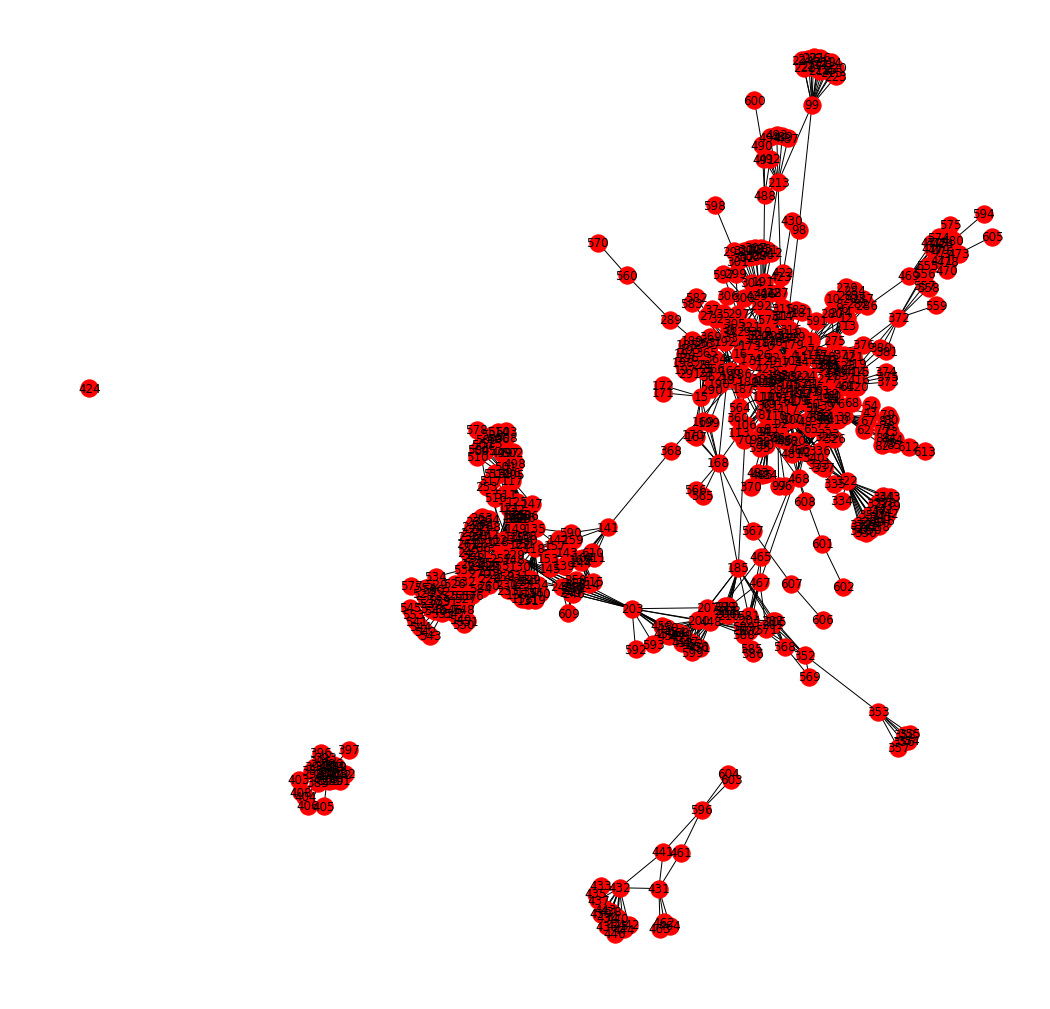

In [763]:
graph_max_edge_btwn_removed(D)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

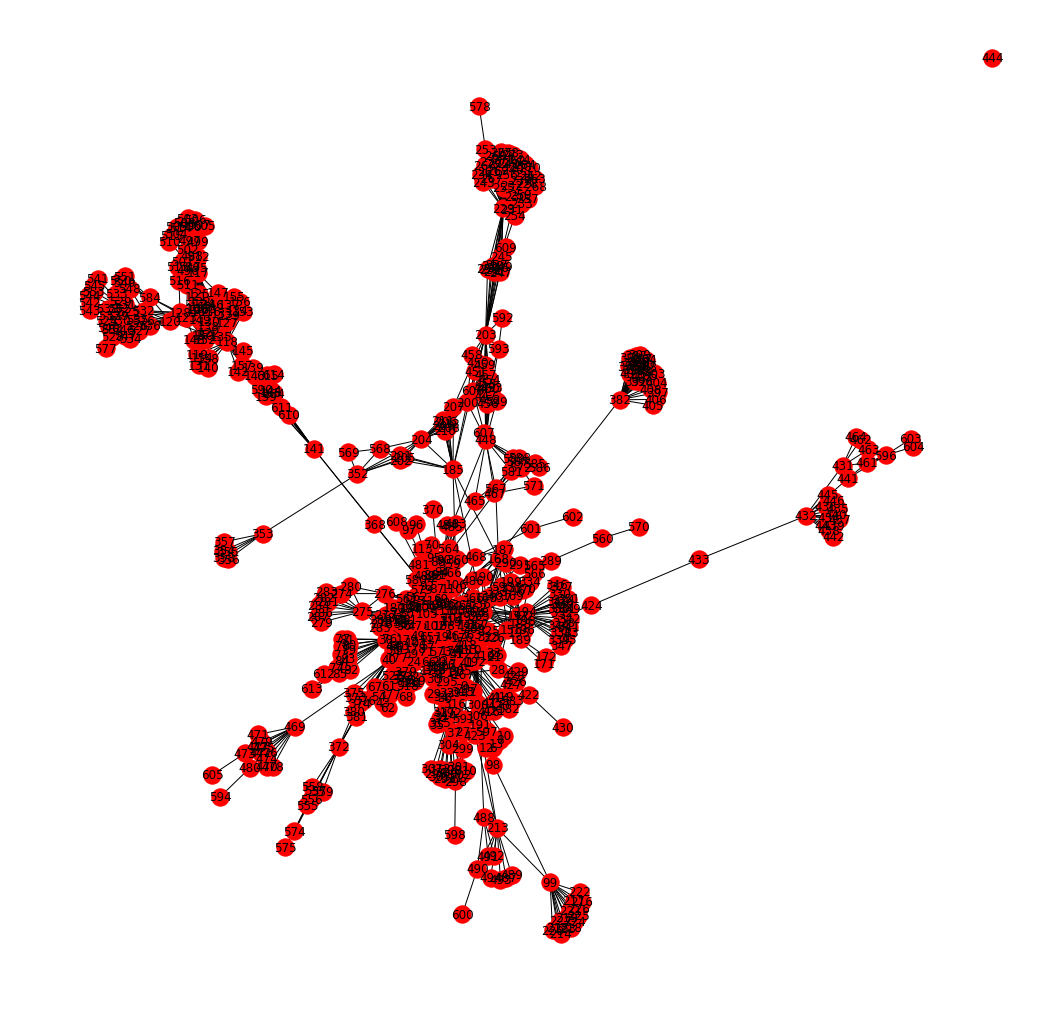

In [764]:
graph_rand_eg_removed(D)

In [849]:
def hub_eg_removed(D):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(distancing_hubs(D)))
    init[186] = 1
    t,p1 = trial(distancing_hubs(D),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(distancing_hubs(D)),'purple',label=('hubs_social_distancing'))
    b=plt.legend()
    return a,b

In [850]:
#betweenness(D)

In [851]:
#random_eg_removed(D)

In [852]:
#hub_eg_removed(D)

<Figure size 432x288 with 0 Axes>

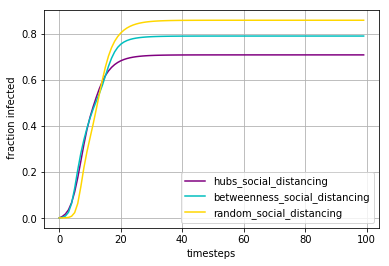

In [853]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
hub_eg_removed(D)
betweenness(D,ax1)
random_eg_removed(D,ax1)

ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Les Mis edge removal

In [854]:
def hub_eg_removed(F):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(distancing_hubs(F)))
    init[24] = 1
    t,p1 = trial(distancing_hubs(F),gamma,beta,m,init)
    a=plt.plot(range(m),t/len(distancing_hubs(F)),'purple',label=('hub_social_distancing'))
    b=plt.legend()
    return a,b

In [855]:
def betweenness(g,ax1):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(max_edge_btwn((g))))
    init[0] = 1
    t,p1 = trial(max_edge_btwn(g),gamma,beta,m,init)
    
    a=ax1.plot(range(m),t/len(max_edge_btwn(g)),'c',label="betweenness_social_distancing")
    #b=plt.legend()
    return a

In [856]:
def random_eg_removed(g,ax1):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(rand_eg(g)))
    init[55] = 1
    t,p1 = trial(rand_eg(g),gamma,beta,m,init)

    a=ax1.plot(range(m),t/len(rand_eg(g)),'gold',label="random_social_distancing")
    #b=plt.legend()
    return a

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

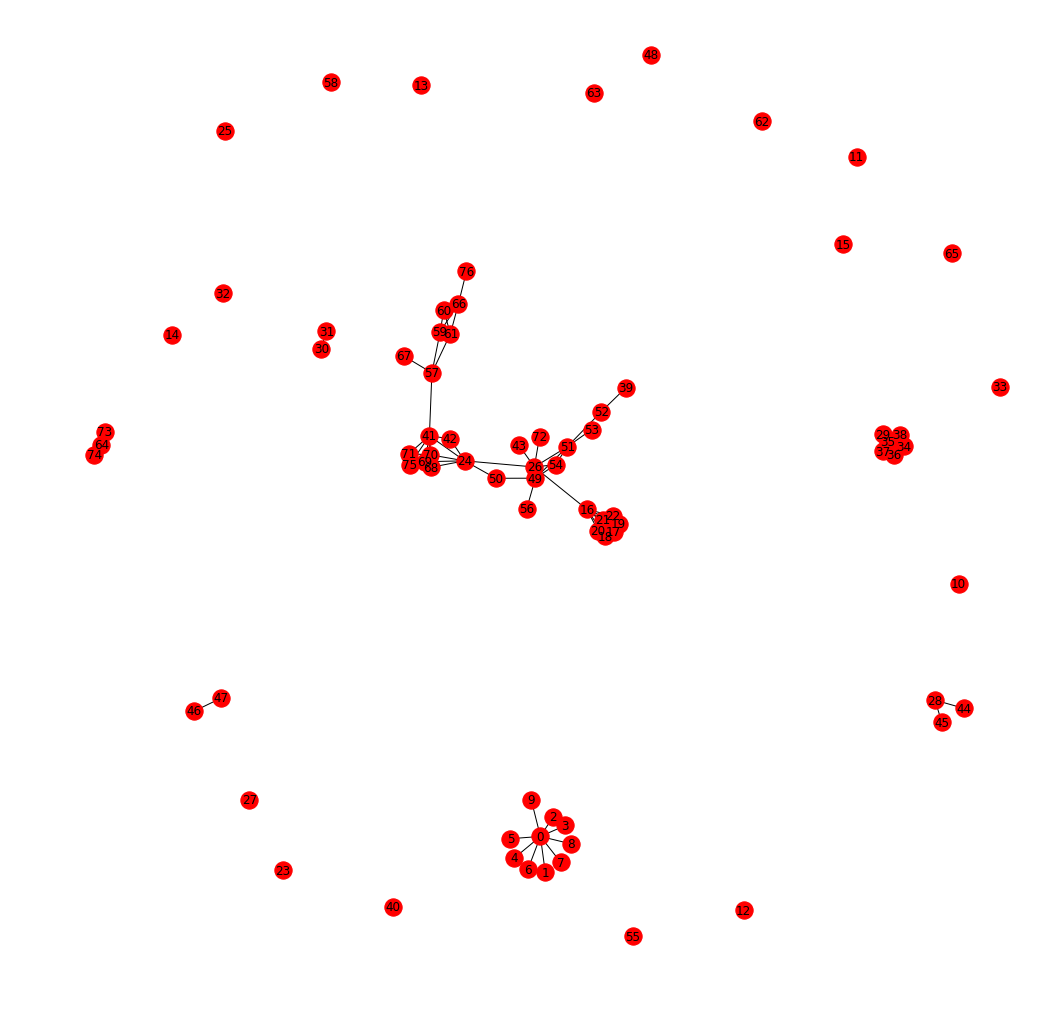

In [857]:
graph_hub_eg_removed(F)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

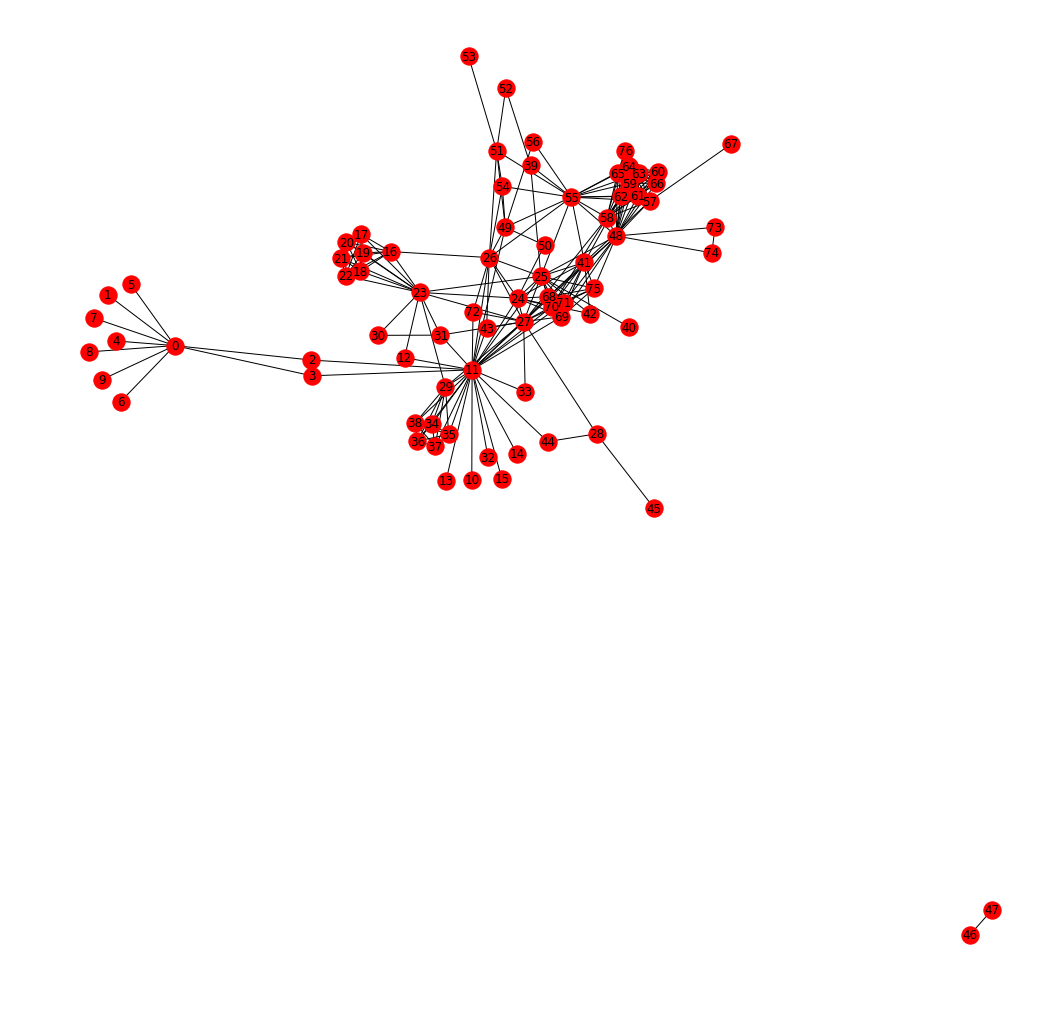

In [774]:
graph_max_edge_btwn_removed(F)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

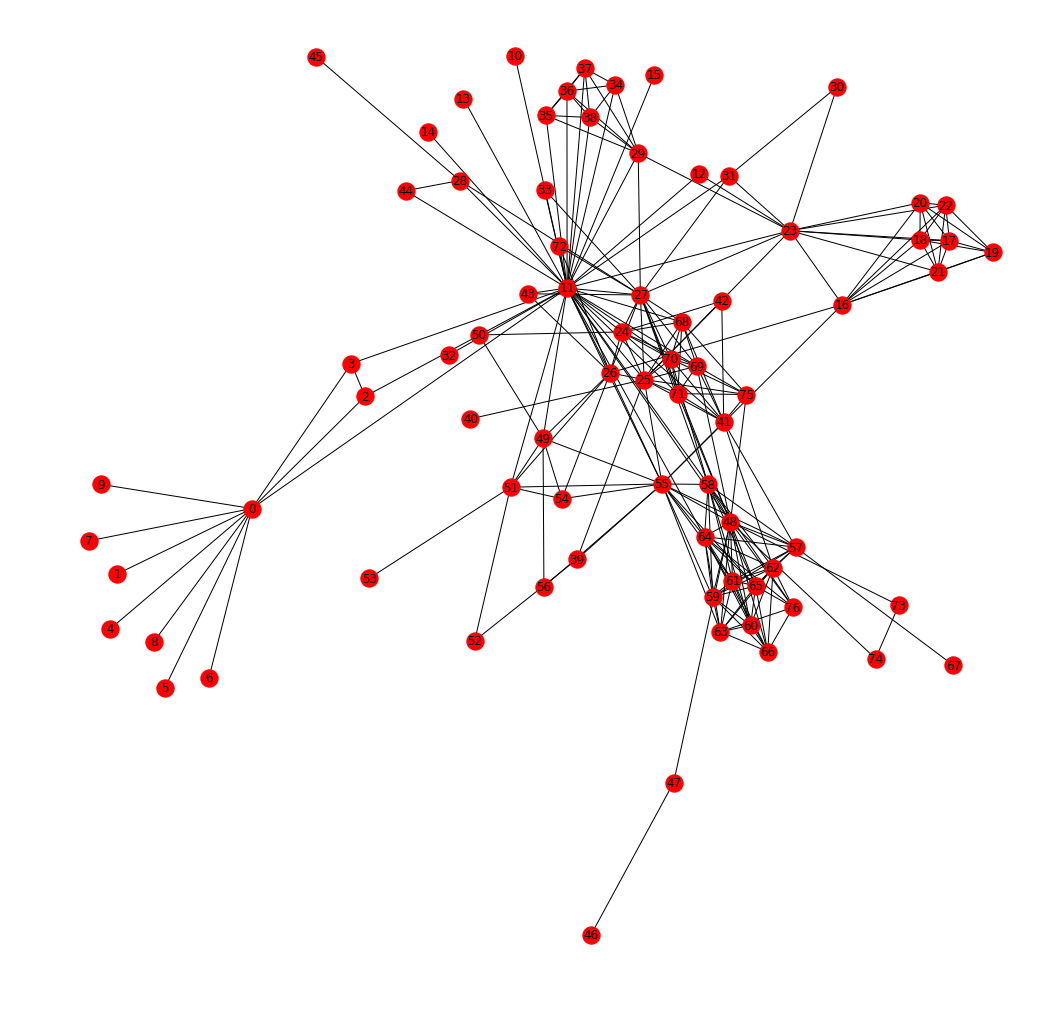

In [775]:
graph_rand_eg_removed(F)

<Figure size 432x288 with 0 Axes>

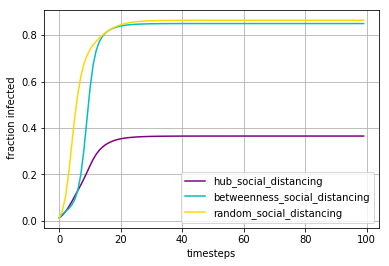

In [858]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
hub_eg_removed(F)
betweenness(F,ax1)
random_eg_removed(F,ax1)

ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
#plt.title("Les Mis")
plt.legend()
plt.show()

# Dolphin Edge removal

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

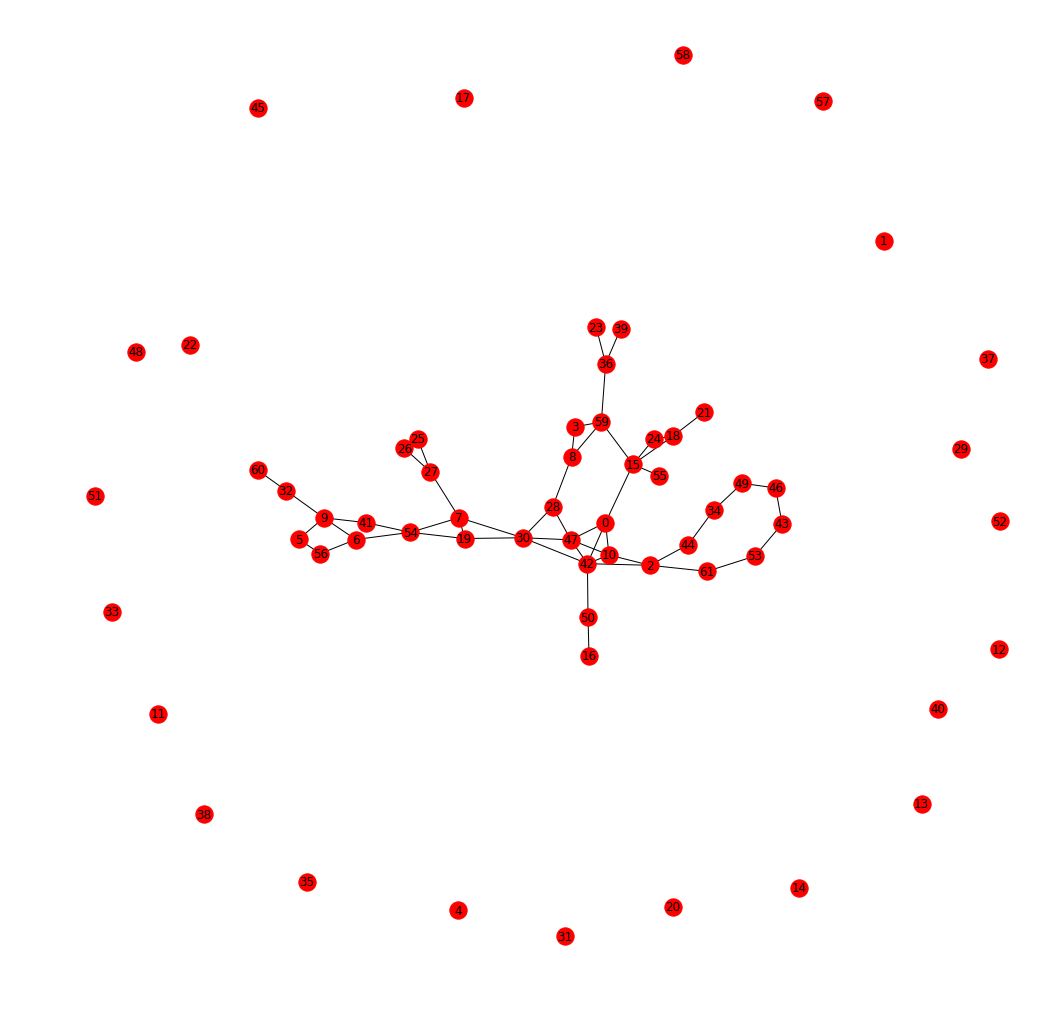

In [780]:
graph_hub_eg_removed(Z)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

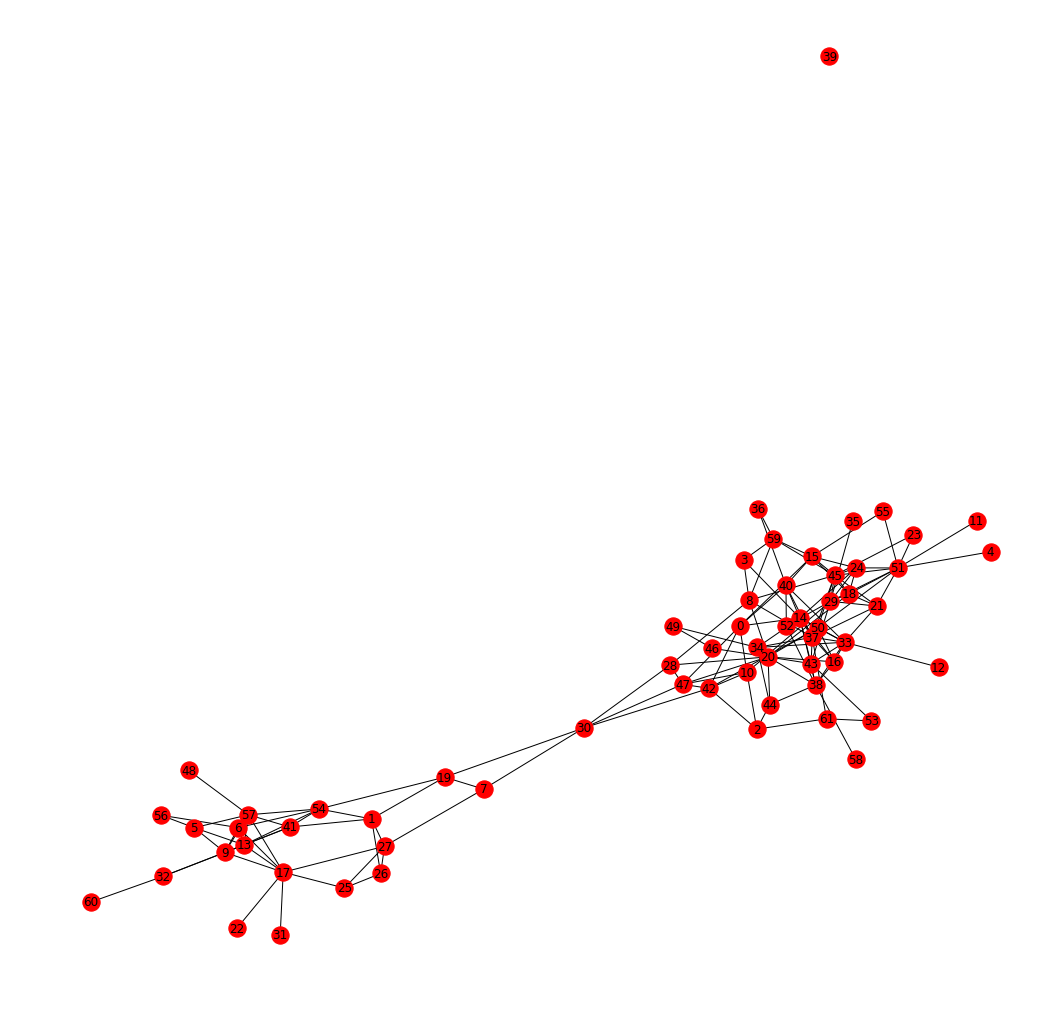

In [781]:
graph_max_edge_btwn_removed(Z)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

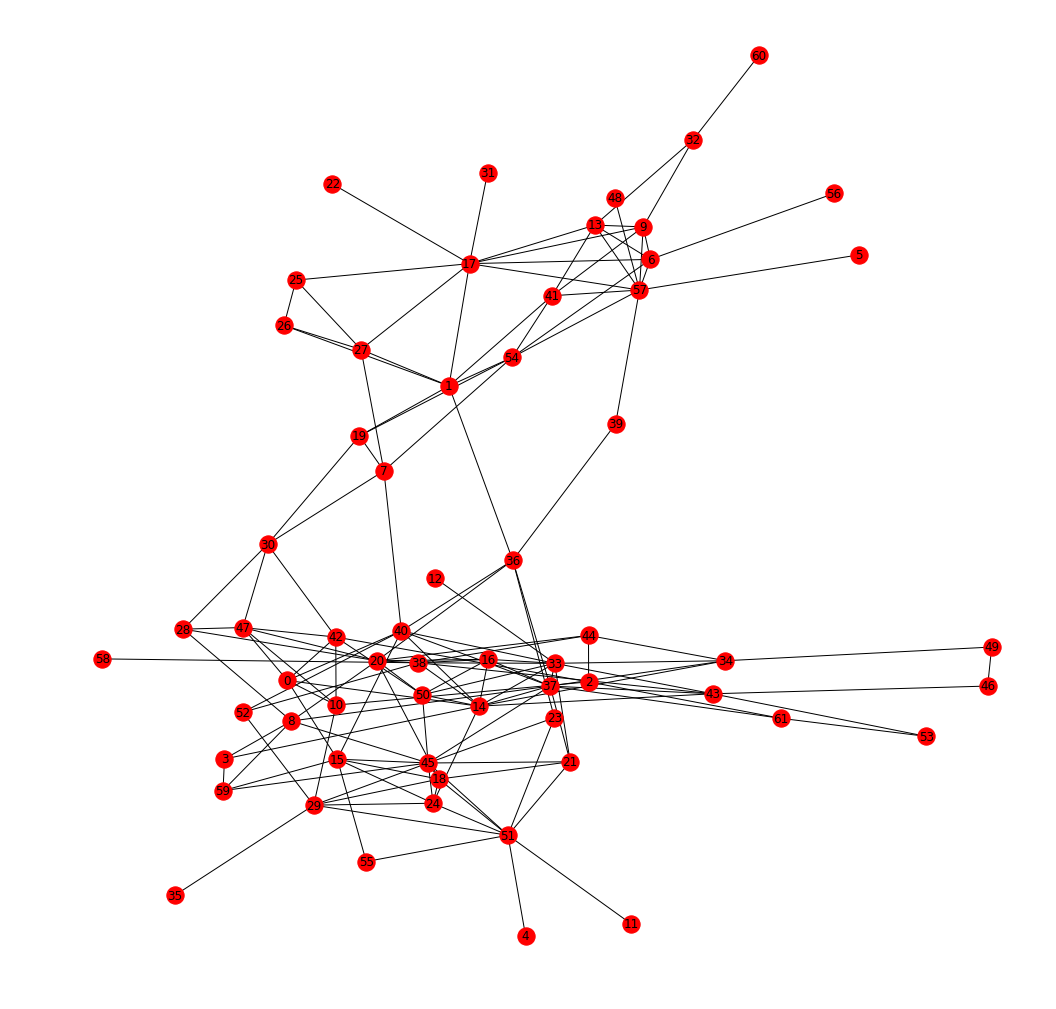

In [782]:
graph_rand_eg_removed(Z)

<Figure size 432x288 with 0 Axes>

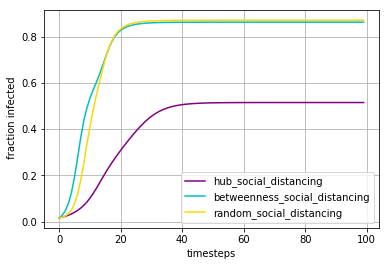

In [859]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
hub_eg_removed(Z)
betweenness(Z,ax1)
random_eg_removed(Z,ax1)

ax1.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# VACCINE VS SOCIAL DISTANCING

<Figure size 432x288 with 0 Axes>

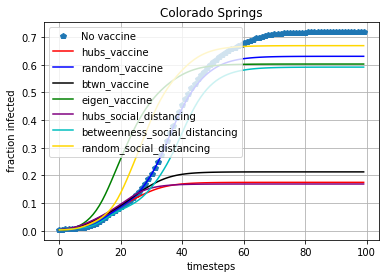

In [895]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),t4/len(G.nodes()),'p',label=("No vaccine"))
plt.plot(range(m),t_1/len(gnow.nodes()),'r',label=("hubs_vaccine"))
plt.plot(range(m),t8/len(g2.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t11/len(g5.nodes()),'k',label=("btwn_vaccine"))
plt.plot(range(m),t13/len(g7.nodes()),'g',label=("eigen_vaccine"))#my_SIS(D3,beta,gamma,t,ax1)
#my_KW(D3,beta,gamma,t,ax1)
hub_eg_removed(G)
betweenness(G,ax1)
random_eg_removed(G,ax1)
plt.grid()
plt.title("Colorado Springs")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

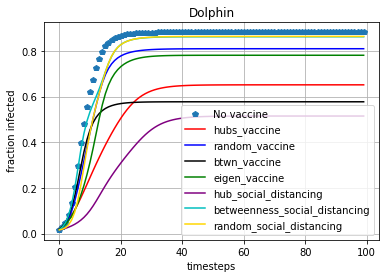

In [861]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m7),t7/len(Z.nodes()),'p',label=("No vaccine"))
plt.plot(range(m),t9/len(g3.nodes()),'r',label=("hubs_vaccine"))
plt.plot(range(m),t10/len(g4.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t12/len(g6.nodes()),'k',label=("btwn_vaccine"))
plt.plot(range(m),t14/len(g8.nodes()),'g',label=("eigen_vaccine"))#my_SIS(D3,beta,gamma,t,ax1)
#my_KW(D3,beta,gamma,t,ax1)hub_eg_removed(Z)
# betweenness(Z,ax1)
# random_eg_removed(Z,ax1)
hub_eg_removed(Z)
betweenness(Z,ax1)
random_eg_removed(Z,ax1)


plt.grid()
plt.title("Dolphin")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

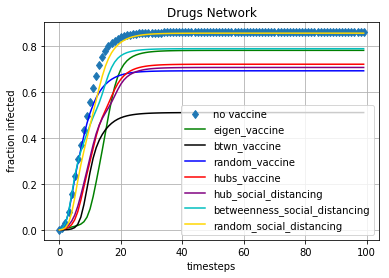

In [865]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m5),t5/len(D.nodes()),"d",label=("no vaccine"))
plt.plot(range(m),t22/len(D3.nodes()),'g',label=("eigen_vaccine"))
plt.plot(range(m),t21/len(D2.nodes()),'k',label=("btwn_vaccine"))
plt.plot(range(m),t20/len(D1.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t19/len(g_D.nodes()),'r',label=("hubs_vaccine"))#my_SIS(D3,beta,gamma,t,ax1)
#my_KW(D3,beta,gamma,t,ax1)
hub_eg_removed(D)
betweenness(D,ax1)
random_eg_removed(D,ax1)

plt.grid()
plt.title("Drugs Network")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

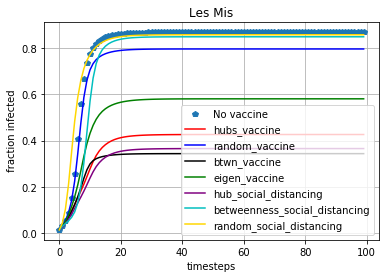

In [863]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m),t8/len(F.nodes()),'p',label=("No vaccine"))
plt.plot(range(m),t15/len(g9.nodes()),'r',label=("hubs_vaccine"))
plt.plot(range(m),t16/len(g10.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t17/len(g11.nodes()),'k',label=("btwn_vaccine"))
plt.plot(range(m),t18/len(g12.nodes()),'g',label=("eigen_vaccine"))#my_SIS(D3,beta,gamma,t,ax1)
#my_KW(D3,beta,gamma,t,ax1)
hub_eg_removed(F)
betweenness(F,ax1)
random_eg_removed(F,ax1)

plt.grid()
plt.title("Les Mis")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

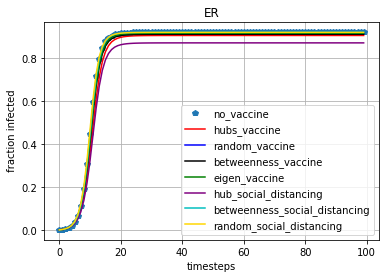

In [883]:
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
ax1.plot(range(m4),t4/len(ER.nodes()),'p',label=("no_vaccine"))
plt.plot(range(m),t_E/len(ER1.nodes()),'r',label=("hubs_vaccine"))
plt.plot(range(m),t_E2/len(ER2.nodes()),'b',label=("random_vaccine"))
plt.plot(range(m),t_E3/len(ER3.nodes()),'k',label=("betweenness_vaccine"))
plt.plot(range(m),t_E4/len(ER4.nodes()),'g',label=("eigen_vaccine"))
hub_eg_removed(ER)
betweenness(ER,ax1)
random_eg_removed(ER,ax1)

plt.grid()
plt.title("ER")
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

# Vaccinating acquintances

In [1050]:
def acquintance(g):
    a=sample(list(g.nodes()), int(0.1*len(g.nodes())))
    k=[]
    for i in a:
        b=sample(list(g.neighbors(i)), 1)
        k.append(b)
        f = []
        for sublist in k: #unpacking list of lists
            for item in sublist:
                f.append(item)
                D=g.copy()
                D.remove_nodes_from(f)
                A=nx.to_numpy_matrix(D)
                D=nx.from_numpy_matrix(A)

    return A

In [1046]:
def random_acquintance(g):
    m=100
    gamma=.08
    beta=.14
    init = np.zeros(len(acquintance(g)))
    init[0] = 1
    t,p1 = trial(acquintance(g),gamma,beta,m,init)

    a=plt.plot(range(m),t/len(acquintance(g)),'gold',label="vaccinating_friends")
    #b=plt.legend()
    return a

In [1049]:
sample(list(D.nodes()), int(0.1*len(D.nodes())))

[260,
 192,
 140,
 196,
 603,
 301,
 502,
 165,
 476,
 533,
 300,
 556,
 124,
 274,
 228,
 520,
 13,
 357,
 36,
 91,
 515,
 83,
 126,
 238,
 106,
 307,
 303,
 97,
 399,
 60,
 407,
 336,
 200,
 314,
 269,
 512,
 569,
 181,
 168,
 318,
 255,
 536,
 316,
 348,
 225,
 54,
 585,
 129,
 552,
 148,
 549,
 160,
 158,
 191,
 339,
 508,
 366,
 281,
 66,
 488,
 20]

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


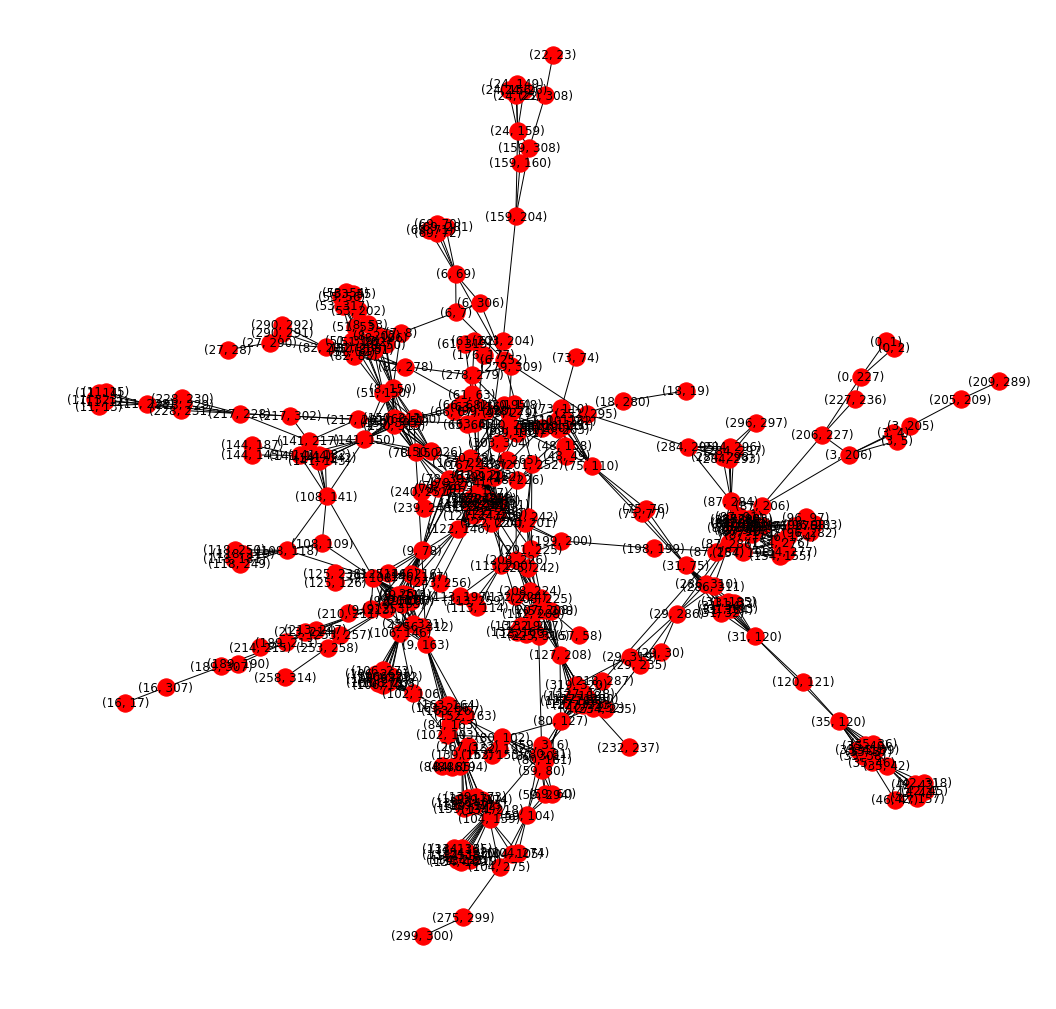

In [1100]:
L = nx.line_graph(G)
plt.figure(figsize=(18,18))

a=nx.draw_networkx(L)
plt.axis('off')
plt.show()

In [1104]:
l=nx.to_numpy_matrix(L)

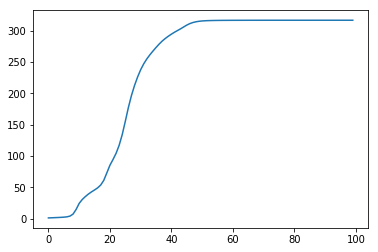

In [1115]:
visualisation(L)

[(87, 96),
 (122, 146),
 (87, 286),
 (99, 122),
 (87, 154),
 (122, 167),
 (63, 122),
 (87, 284),
 (122, 201),
 (122, 200)]

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

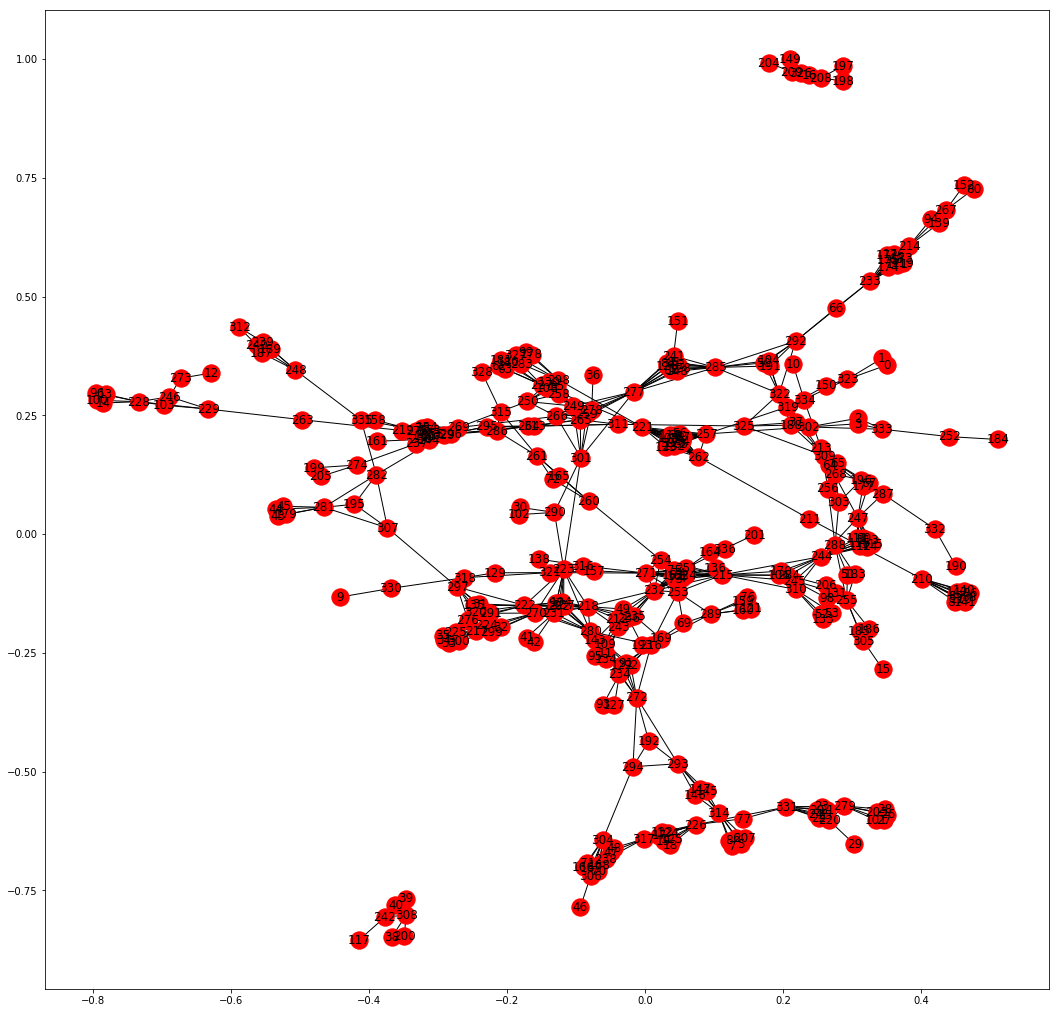

<Figure size 1296x1296 with 0 Axes>

In [1116]:
L1=L.copy()
L1.remove_nodes_from(visualisation(L))
Al=nx.to_numpy_matrix(L1)
L1=nx.from_numpy_matrix(Al)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(L1)
nx.draw_networkx(L1)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [1152]:
print(max(np.linalg.eigvals(Al)))

(15.022619110641633+0j)


In [1153]:
print(max(np.linalg.eigvals(A)))

(4.876695538598261+0j)


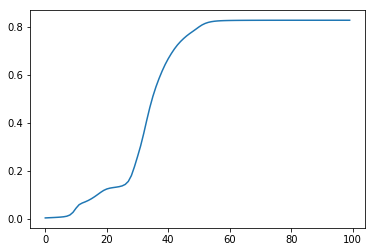

In [1118]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(Al))
init[0] = 1
t30,p1 = trial(Al,gamma,beta,m,init)
plt.clf()
plt.plot(range(m),t30/len(Al))

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 432x288 with 0 Axes>

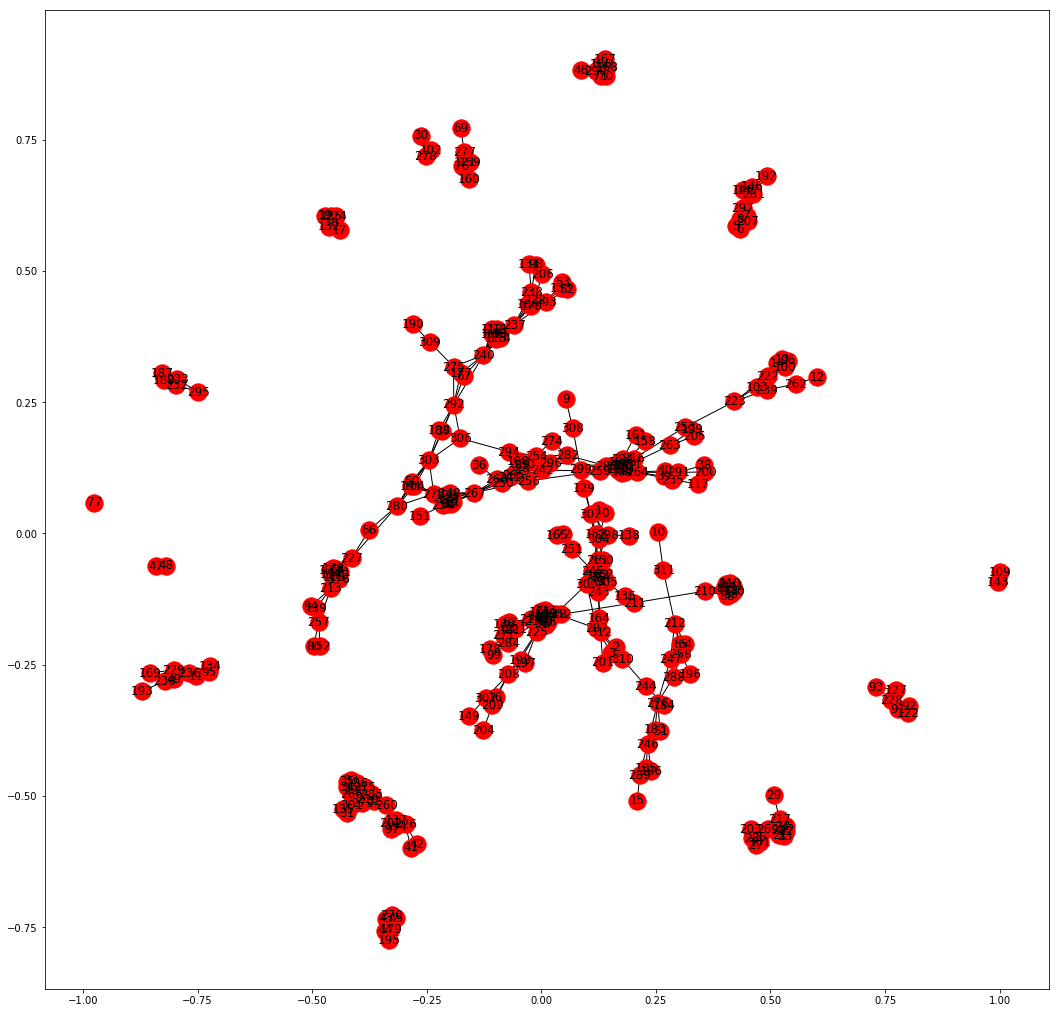

<Figure size 1296x1296 with 0 Axes>

In [1119]:
L2=L.copy()
L2.remove_nodes_from(btwn(L))
Al2=nx.to_numpy_matrix(L2)
L2=nx.from_numpy_matrix(Al2)
plt.clf()
plt.figure(figsize=(18,18))
pos = nx.spring_layout(L2)
nx.draw_networkx(L2)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

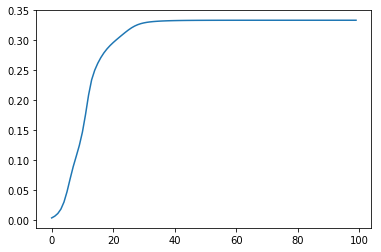

In [1122]:
m=100
gamma=.08
beta=.14
init = np.zeros(len(Al2))
init[280] = 1
t31,p1 = trial(Al2,gamma,beta,m,init)
plt.clf()
plt.plot(range(m),t31/len(Al2))

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


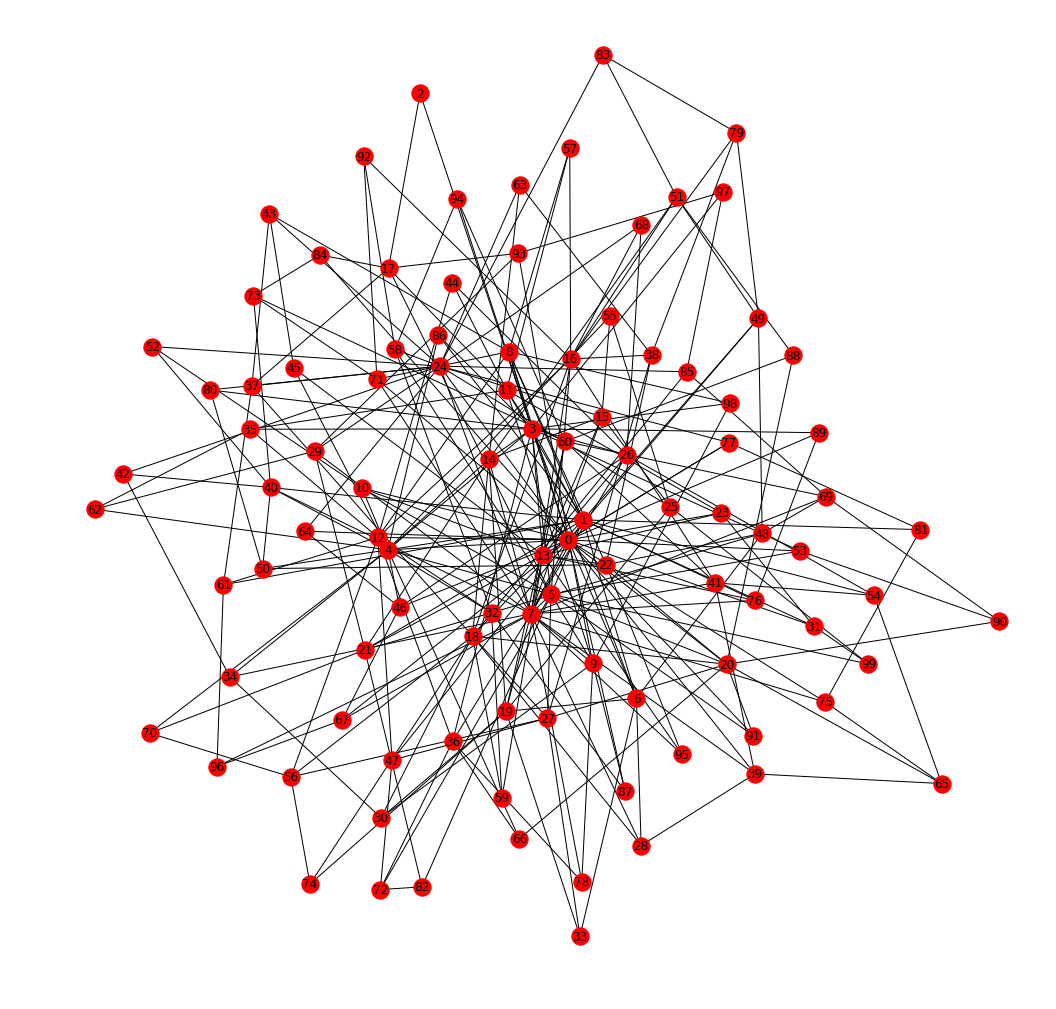

In [8]:
BA=nx.barabasi_albert_graph(100,3,seed=1)
plt.figure(figsize=(18,18))

nx.draw_networkx(BA)
plt.axis('off')
#plt.savefig("pth2.png")
plt.show()

In [9]:
# g3=Z.copy()
# g3.remove_nodes_from(visualisation(Z))
ba=nx.to_numpy_matrix(BA)
BA=nx.from_numpy_matrix(ba)

In [28]:
m=100
gamma=.24
beta=.14
init = np.zeros(len(ba))
init[0] = 1
tba,p1 = trial(ba,gamma,beta,m,init)

<Figure size 432x288 with 0 Axes>

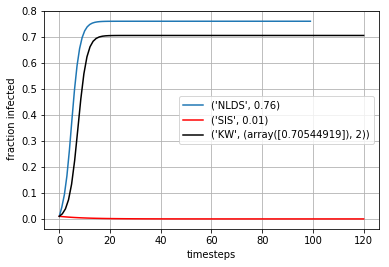

In [29]:
beta=0.14
gamma=0.24
t=np.linspace(0,120,100)
plt.clf()
fig1=plt.figure()
ax1=fig1.add_subplot(111)
plt.plot(range(m),tba/len(BA.nodes()),label=("NLDS",round(max(tba/len(BA.nodes())),2)))
my_SIS(BA,beta,gamma,t,ax1)
my_KW(BA,beta,gamma,t,ax1)
plt.grid()
plt.xlabel('timesteps')
plt.ylabel(' fraction infected')
plt.legend()
plt.show()

In [34]:
prim=nx.read_edgelist('primary.school.proximity.txt')


/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


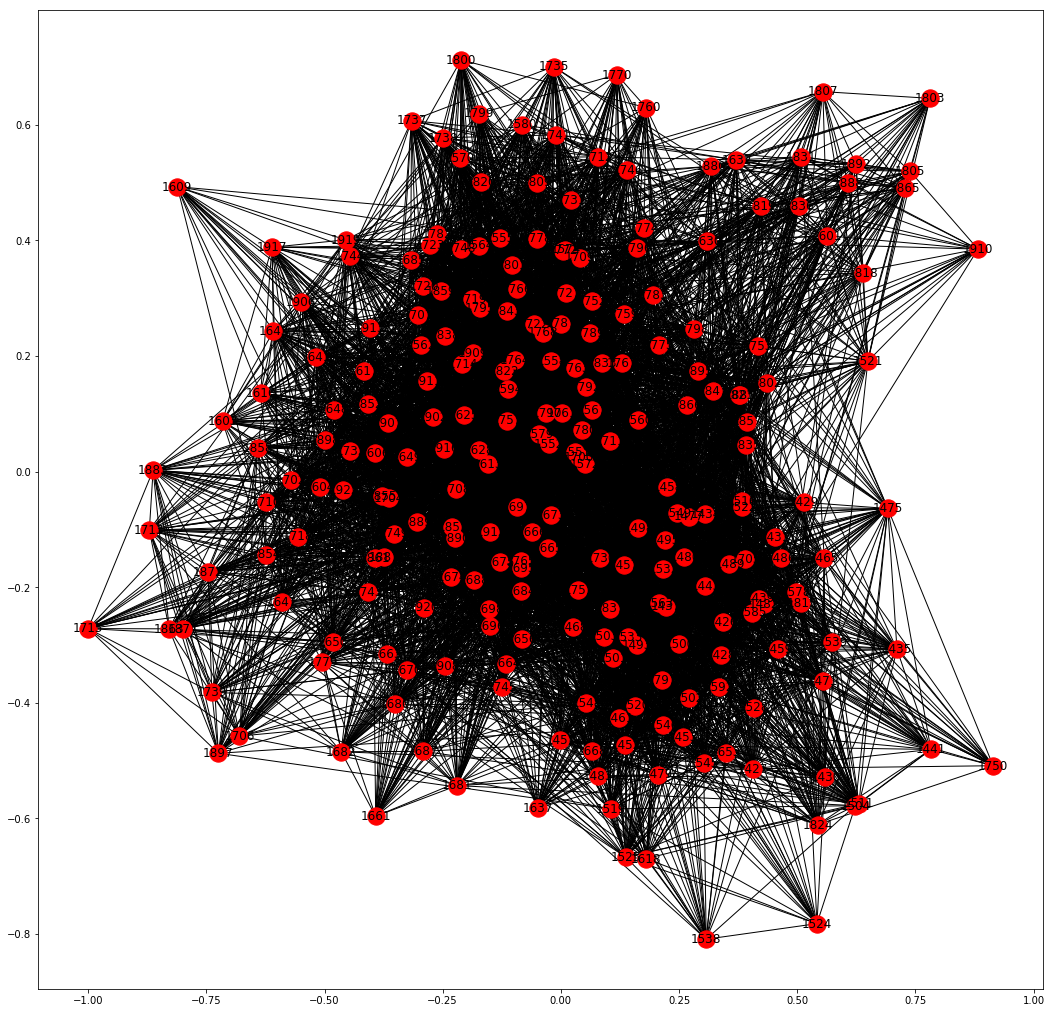

<Figure size 1296x1296 with 0 Axes>

In [35]:
plt.figure(figsize=(18,18))
pos = nx.spring_layout(prim)
nx.draw_networkx(prim)
plt.figure(figsize=(18,18))
#plt.title(title)
plt.show()

In [38]:
def my_communities(g):
    partition = community_louvain.best_partition(g)

    # draw the graph
    pos = nx.spring_layout(g)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    #print(partition)    
    dic={}
    for nodes in partition.keys():
        if partition[nodes] in dic.keys():
            dic[partition[nodes]].append(nodes)
        else:
            dic[partition[nodes]]=[nodes]
    sub={}
    for community in dic.keys():
        sub[community]=g.subgraph(dic[community]) 
        
    len_sub={community:len(sub[community]) for community in sub.keys()}   
    #print(len_sub)
#     plt.figure(figsize=(40,40))   
#     for index,community in enumerate(dic.keys()):
#         plt.subplot(len(sub),1,index+1)
#         r= nx.draw_networkx(sub[community])

    for community in sub.keys():
        if len_sub[community]==max(len_sub.values()): # getting the largest community
            p=sub[community]
            #print(len(sub[community]))
            #d=nx.draw_networkx(p)
            break
    e=nx.to_numpy_matrix(p)
    return p

In [39]:
my_communities(G)

NameError: name 'community_louvain' is not defined

In [44]:
nx.average_node_connectivity(G)

1.0202193938004052

In [45]:
nx.average_node_connectivity(F)

2.2624743677375254

In [46]:
nx.average_node_connectivity(D)

NameError: name 'D' is not defined

In [34]:
rd=nx.read_edgelist('road2.txt')

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


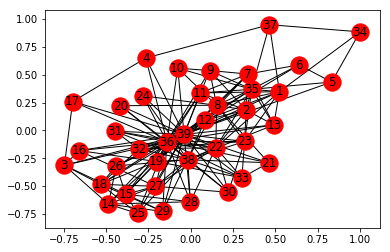

In [35]:
nx.draw_networkx(rd)

In [31]:
rd.number_of_nodes()

39